In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import struct
import imageio
import collections
import pickle
import re
import requests
import pandas as pd
from pathlib import Path
import pretty_errors
from filter_BU import filt_B
import my_pyrotd
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
# InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
rcparams = {'font.size': 16,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'lines.linewidth': 1.5,
            'figure.dpi': 300}
plt.rcParams.update(rcparams)
plt.style.use('seaborn')

<Figure size 432x288 with 0 Axes>

## Initialization

### Parameters

In [2]:
# band pass filter
lowf, highf = 0.1, 4
freqs = np.concatenate((np.logspace(-1, 1, 91),
                        [1/3, 2, 3, 4, 5]))
freqs = sorted(freqs)

mx, my = 3456, 3456
tmax, dt, dh = 30, 0.001, 0.008
tskip, wstep = 20, 300

dt = dt * tskip
nt = int(tmax / dt)
fs = 1 / dt
nfile = nt // wstep

# sites of recordings
r = requests.get('http://hypocenter.usc.edu/research/High-F/lahabra_obs_2019_05_31/')
rec_sites = re.findall('(?<=V2">).+V2(?=<)', r.text)

temp = np.genfromtxt('la_habra_small_statlist_3456.idx', delimiter=" ", dtype="S8, i4, i4")
syn_sites = [(name.decode('UTF-8').replace('_', ''), ix, iy) for name, ix, iy in temp \
             if 0 < ix < mx - 1 and 0 < iy < my - 1]

### Functions

#### read_params

In [3]:
def read_params(model):
    with open(Path(model, 'param.sh'), 'r') as fid:
        for line in fid:
            if "TMAX" in line:
                tmax = float(re.findall(r'(?<=TMAX )\d+\.+\d+(?= )', line)[0])
            if "DT" in line:
                dt = float(re.findall(r'(?<=DT )\d+\.+\d+(?= )', line)[0])
            if "NTISKP" in line:
                tskip = int(re.findall(r'NTISKP (\d+)', line)[0])
                dt = dt * tskip
            if "WRITE_STEP" in line:
                wstep = int(re.findall(r'WRITE_STEP (\d+)', line)[0])
    nfile = int(tmax / dt) // wstep
    return tmax, dt, tskip, wstep, nfile

#### check_mesh_cont

In [4]:
def check_mesh_cont(fmesh_0, fmesh_1, nx, ny, nz, verbose=False, nvar=3, skip=3):
    max_diff = 0
    with open(fmesh_0, 'rb') as f0, open(fmesh_1, 'rb') as f1:
        f0.seek(4 * nvar * nx * ny * (nz - 8), 0)
        for i in range(3):       
            data0 = np.frombuffer(f0.read(4 * nvar * nx * ny),
                                  dtype='float32').reshape(ny, nx, nvar)
            data1 = np.frombuffer(f1.read(4 * nvar * nx * ny // skip ** 2),
                                  dtype='float32').reshape(ny//skip, nx//skip, nvar)
            diff = data0[1::skip, ::skip, :] - data1
            max_diff = max(np.max(diff), max_diff)
            #print(data0[:5, :5, 1], data1[:2, :2, 1])
            if not np.isclose(diff, 0).all():
                loc_y, loc_x, loc_z = np.unravel_index(
                                      np.argmax(np.abs(diff)), diff.shape)
                if verbose:
                    print(f"Not consistent, max difference at {np.argmin(diff)}: {np.min(diff)}")
                    print(f"({loc_y}, {loc_x}, {loc_z}) in {diff.shape}")
                    print("Top block: ", data0[1 + skip * loc_y, skip * loc_x, loc_z])
                    print("Bottom block: ", data1[loc_y, loc_x, loc_z])
            f0.seek(4 * nvar * nx * ny * 2, 1)
    if np.isclose(0, max_diff):
        print("Top and bottom blocks are consistent!")   
    else:
        im=plt.imshow(diff[:, :, loc_z], cmap='RdBu')
        plt.colorbar(im)
        print(f"Top and bottom blocks are not consistent! Max_diff = {max_diff}")
    return True

#### read_snapshot

In [5]:
def read_snapshot(it, model="", case="", comp="X"):
    tmax, dt_syn, tskip, wstep, nfile = read_params(model)

    model = Path(model, "output_sfc" if not case else f"output_sfc_{case}")
    fnum = int(np.ceil((it + 1) / wstep) * wstep * tskip)
    print(f'\r{it} / {nt}, fnum={fnum}', end="\r", flush=True)
    fid = open(f'{model}/S{comp}_0_{fnum:07d}', 'rb')
    skip = 4 * ((it - fnum // tskip + wstep) * mx * my)
    fid.seek(skip, 0)
    v = np.frombuffer(fid.read(mx * my * 4), dtype='float32').reshape(my, mx)
    v = v.copy()
    if np.isnan(v).any():
        print(f"NAN founded\n")
    return v

#### plot_snapshot

In [6]:
def plot_snapshot(it, model="", case="", draw=False):   
    vx = read_snapshot(it, model=model, case=case)
    fig, ax = plt.subplots()
    im = ax.imshow(vx.T,cmap='bwr')
    cb = plt.colorbar(im)
    cb.ax.set_ylabel('V (m/s)')
    ax.set(xlabel='X', ylabel='Y', title=f'T = {it * dt:.2f}s')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    if not draw:
        plt.close(fig)
    return image

#### read_syn

In [7]:
def read_syn(ix, iy, model="", case=""):
    data = collections.defaultdict(list)
    tmax, dt_syn, tskip, wstep, nfile = read_params(model)

    model = Path(model, "output_sfc" if not case else f"output_sfc_{case}")
    skips = [4 * (j * my * mx + iy * mx + ix) for j in range(wstep)]
    for comp in ["X", "Y", "Z"]:
        for i in range(1, nfile + 1):
            # print(f"\rProcessing step {i}: S{comp}_0_{i * wstep * tskip:07d}", end="\r", flush=True)
            with open(f'{model}/S{comp}_0_{i * wstep * tskip:07d}', 'rb') as fid:
                for j in range(wstep):
                    fid.seek(skips[j], 0)
                    data[comp] += struct.unpack('f', fid.read(4))     

        if np.isnan(data[comp]).any():
            print(f"\nNAN in file {model}/S{comp}_0_{(i - 1) * wstep * tskip}\n")
            return None
        #data[comp] = filt_B(np.array(data[comp], dtype='float32'), 1 / dt_syn, causal=False)
        data[comp] = np.array(data[comp])
        print(f'{model}/S{comp}_0_{i * wstep * tskip:07d}')
    data['X'] = -data['X']
    data['dt'] = dt_syn
    return data

#### read_rec

In [8]:
def read_rec(site, metric='vel'):
    r = requests.get(f'http://hypocenter.usc.edu/research/High-F/lahabra_obs_2019_05_31/{site}.V2')
    if r.status_code != 200:
        print(f"the site {site} not found on the server")
        return None
    recordings = r.text.split('\r\n')

    stime = re.findall('\d+:\d+:\d+', recordings[4].split(',')[1])[0].split(':')
    channel = {1: "X", 2: "Z", 3: "Y"}
    count = 0
    data = {}
    for i in range(len(recordings)):
        if "points" in recordings[i] and metric in recordings[i]:    
            nums = re.findall('\d*\.*\d+', recordings[i])
            if len(nums) <= 1:  # skip headers
                continue
            count += 1
            npts = int(nums[0])
            dt_rec = float(nums[1])        
            start = i + 1
            end = i + (npts - 1) // 8 + 2
            # convert cm/s/s to m/s/s
            data[channel[count]] = np.array([float(x) / 100 for y in recordings[start : end] \
                                           for x in y.replace('-', ' -').split()])
            assert(len(data[channel[count]]) == npts)
            # data[channel[count]] = filt_B(np.array(data[channel[count]], dtype='float32'),1 / dt_rec, causal=False)
    print(f"Number of points = {npts}, dt_recording = {dt_rec}")
    data["dt"] = dt_rec
    return data

#### pick_vel

In [9]:
def pick_vel(models):
    try: 
        with open('results/vel_rec.pickle', 'rb') as fid:
            vel_rec = pickle.load(fid)
        with open('results/vel_syn.pickle', 'rb') as fid:
            vel_syn = pickle.load(fid)
        with open('results/vel_rwg.pickle', 'rb') as fid:
            vel_syn['rwg'] = pickle.load(fid)
    except Exception as e:
        vel_rec = {}
        vel_syn = collections.defaultdict(dict)
    
    if all(x in vel_syn.keys() for x in models):
        print("Models queried!")
        return vel_rec, {k:vel_syn[k] for k in models}
    init_len = len(vel_syn)
    _models = models.copy()
    for key in vel_syn.keys():
        if key in _models:
            _models.remove(key)
    for isite in range(len(syn_sites)):
        site_name = syn_sites[isite][0]
        print(f'Gathering {len(_models)} ground motions at site {site_name}')
        ix, iy = syn_sites[isite][1:]
        if site_name not in vel_rec:
            vel_rec[site_name] = read_rec(site_name)
        for model in _models:
            vel_syn[model][site_name] = read_syn(ix, iy, model=model) 
            
    if len(vel_syn) > init_len:
        with open('results/vel_rec.pickle', 'wb') as fid:
            pickle.dump(vel_rec, fid, protocol=pickle.HIGHEST_PROTOCOL)
        with open('results/vel_syn.pickle', 'wb') as fid:
            pickle.dump(vel_syn, fid, protocol=pickle.HIGHEST_PROTOCOL)
            
            
    return vel_rec, {k: vel_syn[k] for k in models}

#### pick_psa

In [10]:
def pick_psa(models, osc_freqs=freqs, osc_damping=0.05):
    '''Import psa response if available
    If psa pickle files don't exist, create them.
    If some other models are queried, compute them and append to psa files.
    '''
    try: 
        with open('results/psa_rec.pickle', 'rb') as fid:
            rotd_rec = pickle.load(fid)
        with open('results/psa_syn.pickle', 'rb') as fid:
            rotd_syn = pickle.load(fid)
    except Exception as e:
        rotd_rec = dict()
        rotd_syn = collections.defaultdict(dict)
    
    if all(x in rotd_syn.keys() for x in models):
        print("Models queried!")
        return rotd_rec, {k:rotd_syn[k] for k in models}
    
    # Remove existing models except extra model queried
    init_len = len(rotd_syn)
    _models = models.copy()   
    for key in rotd_syn.keys():
        if key in _models:
            _models.remove(key)
    vel_rec, vel_syn = pick_vel(models.copy())
            
    for isite in range(len(syn_sites)):
        print(f"\rComputing site {isite} / {len(syn_sites)}", end="\r", flush=True)
        site_name = syn_sites[isite][0]
        if site_name not in rotd_rec:
            print(f"\nGathering rotd_rec for {site_name}\n")
            # If site not found on the server
            if not vel_rec[site_name]:
                continue
            accx, accy = (np.diff(x, prepend=0) / vel_rec[site_name]['dt'] \
                          for x in [vel_rec[site_name]['X'], vel_rec[site_name]['Y']])
            rotd_rec[site_name] = my_pyrotd.my_calc_rotated_spec_accels(
                vel_rec[site_name]['dt'], accx, accy,
                osc_freqs, osc_damping, percentiles=[50])

        for model in _models:
            print(f"\rGathering rotd_syn for {site_name} of {model}", end='\r', flush=True)
            accx, accy = (np.diff(x, prepend=0) / vel_syn[model][site_name]['dt'] \
                          for x in [vel_syn[model][site_name]['X'], vel_syn[model][site_name]['Y']])
            rotd_syn[model][site_name] = my_pyrotd.my_calc_rotated_spec_accels(
                vel_syn[model][site_name]['dt'], accx, accy,
                osc_freqs, osc_damping, percentiles=[50])
    
    # Rewrite if more models queried than existing
    if len(rotd_syn) > init_len:
        with open('results/psa_rec.pickle', 'wb') as fid:
            pickle.dump(rotd_rec, fid, protocol=pickle.HIGHEST_PROTOCOL)
        with open('results/psa_syn.pickle', 'wb') as fid:
            pickle.dump(rotd_syn, fid, protocol=pickle.HIGHEST_PROTOCOL)
            
    return rotd_rec, {k:rotd_syn[k] for k in models}

#### plot_validation

In [11]:
def plot_validation(isite, models, shift=24, lowcut=lowf, highcut=highf, metrics=['vel', 'pas']):
    vel_rec, vel_syn = pick_vel(models)
    psa_rec, psa_syn = pick_psa(models)
    
    site_name = syn_sites[isite][0]
    if not vel_rec[site_name]:
        return None
    ix, iy = syn_sites[isite][1:]
    dt_rec = vel_rec[site_name]['dt']   
    len_rec = len(vel_rec[site_name]['X'])
    len_syn = len(vel_syn[models[0]][site_name]['X'])
    t_rec = np.arange(len_rec) * dt_rec
    
    comp = {0: "X", 1: "Y", 2: "Z"}
    image =[]
    if 'vel' in metrics:
        fig, ax = plt.subplots(3, 1, dpi=400)
        fig.tight_layout()
        fig.suptitle(f'{site_name}')
        for i in range(3):   
            vel = filt_B(vel_rec[site_name][comp[i]],1 / dt_rec, causal=False)
            ax[i].plot(t_rec, vel, label='rec')
            for model in models:
                dt_syn = vel_syn[model][site_name]['dt']
                len_syn = len(vel_syn[model][site_name]['X'])
                t_syn = np.arange(len_syn) * dt_syn + shift
                vel = filt_B(vel_syn[model][site_name][comp[i]], 1 / dt_syn, causal=False)
                ax[i].plot(t_syn, vel, label=model)

            ax[i].set_ylabel(f'V{comp[i]} (m/s)')
            ax[i].set_xlim(shift)
        ax[-1].set_xlabel('Time (s)')
        ax[0].legend()
        fig.canvas.draw()
        temp = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image += [temp.reshape(fig.canvas.get_width_height()[::-1] + (3,))]
    
    if 'psa' in metrics:
        fig, ax = plt.subplots(dpi=400)
        fig.tight_layout()
        fig.suptitle(f'{site_name}') 
        psa = psa_rec[site_name]
        ax.plot(psa.osc_freq, psa.spec_accel, label='rec')
        for model in models:
            psa = psa_syn[model][site_name]
            ax.plot(psa.osc_freq, psa.spec_accel, label=model)
        ax.set(ylabel=f'$SA (m/s^2)$', xscale='log', yscale='log')
        ax.xaxis.grid(True, which='both')
        ax.yaxis.grid(True, which='both')
        ax.set_xlabel('Frequency (Hz)')
        ax.legend()
        fig.canvas.draw()
        temp = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image += [temp.reshape(fig.canvas.get_width_height()[::-1] + (3,))]
                             
    return image

## Synthetics

In [12]:
models = ["noqf_orig", "qf04_orig", "qf06_orig", "qf08_orig", "noqf_s05h005l100",
          "qf04_s05h005l100", "qf06_s05h005l100", "qf08_s05h005l100",
          "qf06_s05h005l200", "qf06_s05h005l500", "qf06_s05h010l100",
          "qf06_s05h010l500", "qf06_s05h015l100", "qf06_s10h005l100",
          "topo_qf06_s05h005l100", 'rwg']
vel_rec, vel_syn = pick_vel(models) 
psa_rec, psa_syn = pick_psa(models) 

Models queried!
Models queried!


In [12]:
stat_list = pd.read_csv(r'../scripts/la_habra_large_statlist.txt', delimiter=" ",
                        header=None, usecols=[0])
stat_list =stat_list[0].tolist()
with open('results/vel_rec.pickle', 'rb') as fid:
    vel_rec = pickle.load(fid)
with open('results/vel_syn.pickle', 'rb') as fid:
    vel_syn = pickle.load(fid)
with open('results/vel_rwg.pickle', 'rb') as fid:
    vel_rwg = pickle.load(fid)

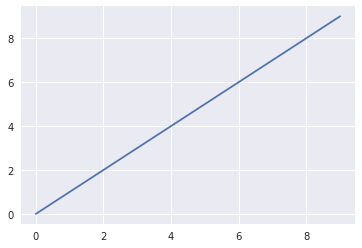

In [24]:
%matplotlib inline
plt.plot(np.arange(10))

(0, 30)

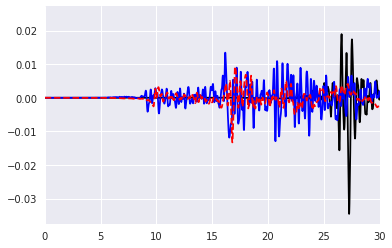

In [25]:
plt.plot(vel_rec['CE14006']['dt'] * np.arange(len(vel_rec['CE14006']['X'])), vel_rec['CE14006']['X'], 'k')
plt.plot(vel_syn['topo_qf06_s05h005l100']['CE14006']['dt'] * np.arange(len(vel_syn['topo_qf06_s05h005l100']['CE14006']['X'])), vel_syn['topo_qf06_s05h005l100']['CE14006']['X'], 'b')

plt.plot(vel_syn['rwg']['CE14006']['dt'] * np.arange(len(vel_syn['rwg']['CE14006']['X'])), vel_syn['rwg']['CE14006']['X'], 'r--')
plt.xlim(0, 30)

['CE_12919', 'CE_13066', 'CE_13067', 'CE_13068']
57


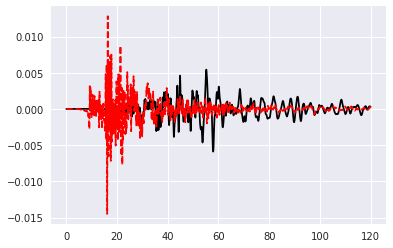

In [42]:

            
print(stat_list[:4])
vx =  np.fromfile('../la_habra_large_gpu_dm_abc50_noQf/seis_x0120000',
                 dtype='float32').reshape(len(stat_list), -1)
vx = np.fromfile('')
vx2 =  np.fromfile('../la_habra_large_gpu_dm_abc50/BW_results/seis_x0120000',
                 dtype='float32').reshape(len(stat_list), -1)
plt.plot(0.01 * np.arange(vx.shape[-1]), vx[57,:], 'k')
print(stat_list.index('CE_14006'))
plt.plot(0.01 * np.arange(np.shape(vx)[-1]),vx2[57,:], 'r--')
#plt.xlim(1000, 5000)
#for F in stat_list:
#    vx = 

### Validation

In [16]:
image = plot_validation(0, ['topo_qf06_s05h005l100', 'qf06_s05h005l100'], shift=22, metrics=['vel'])

Models queried!
Models queried!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

AttributeError: 'Canvas' object has no attribute 'renderer'

In [23]:
print(mpl.get_backend())
plt.plot(vel_rec['CE14006']['X'])

module://ipympl.backend_nbagg


### Initialize container

In [17]:
image=plot_validation(2, ["topo_qf06_s05h005l100"], shift=23, metrics=['vel', 'psa'])


Models queried!
Models queried!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

AttributeError: 'Canvas' object has no attribute 'renderer'

Models queried!
Models queried!


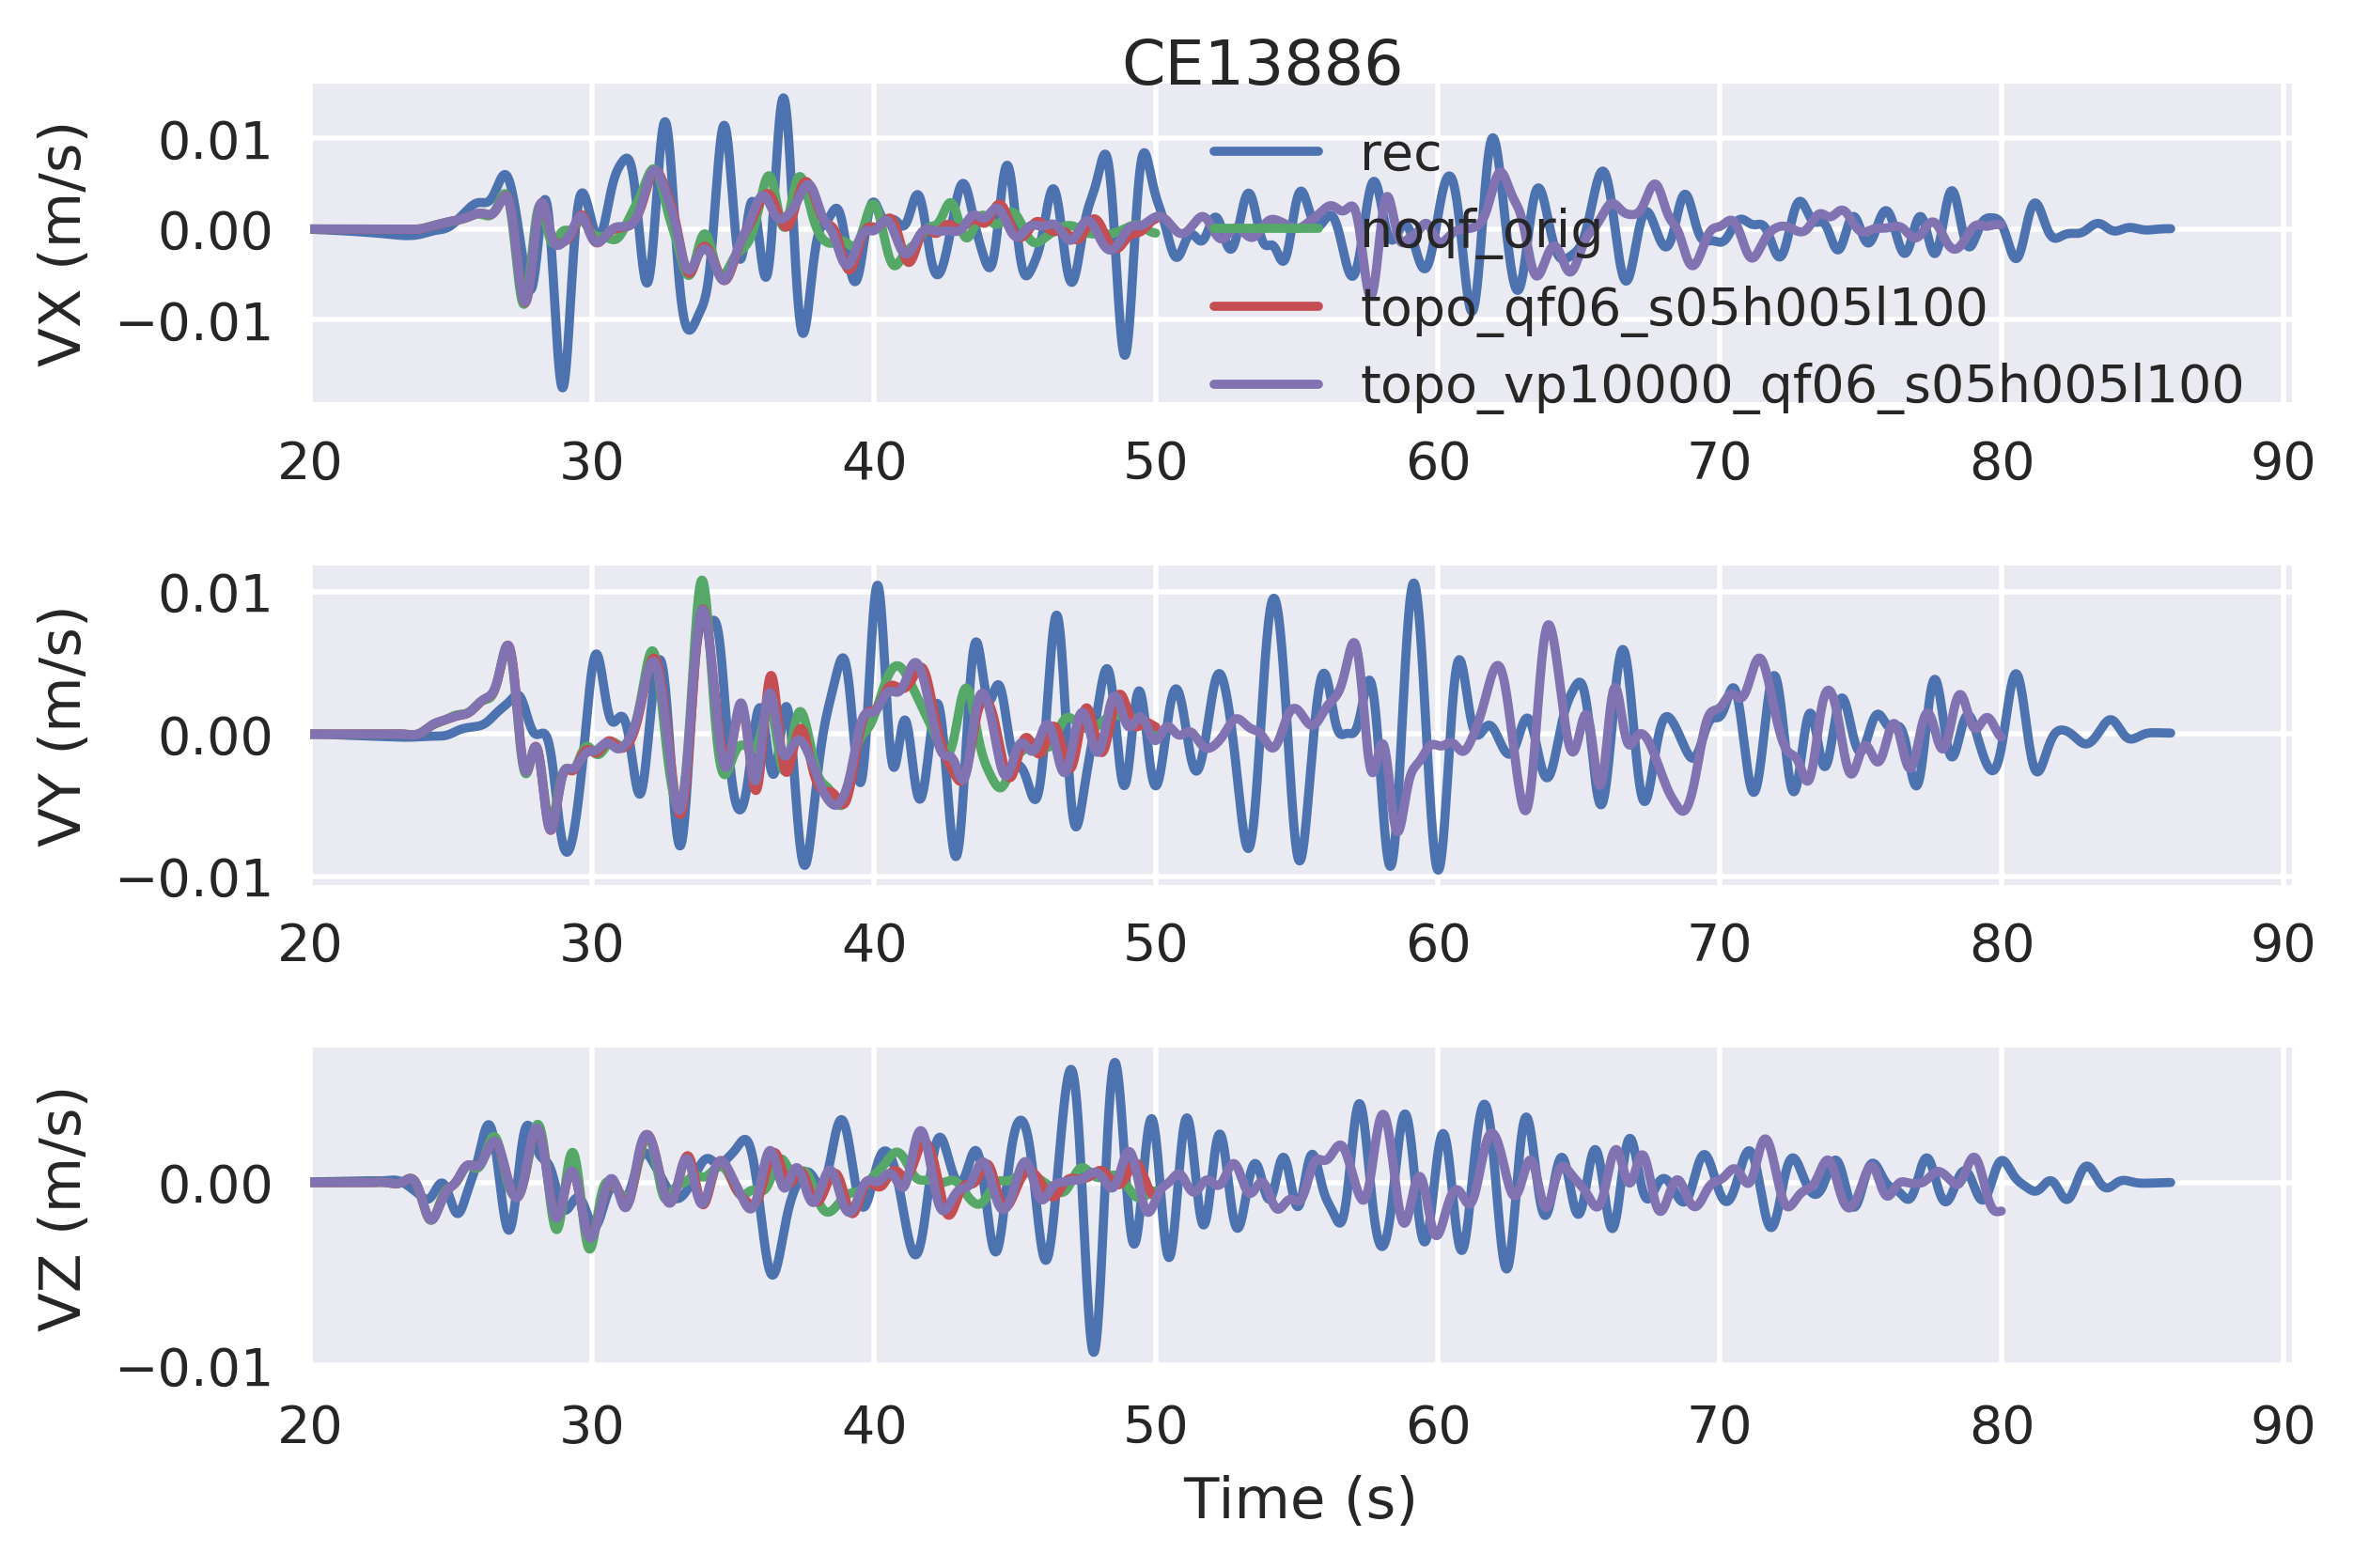

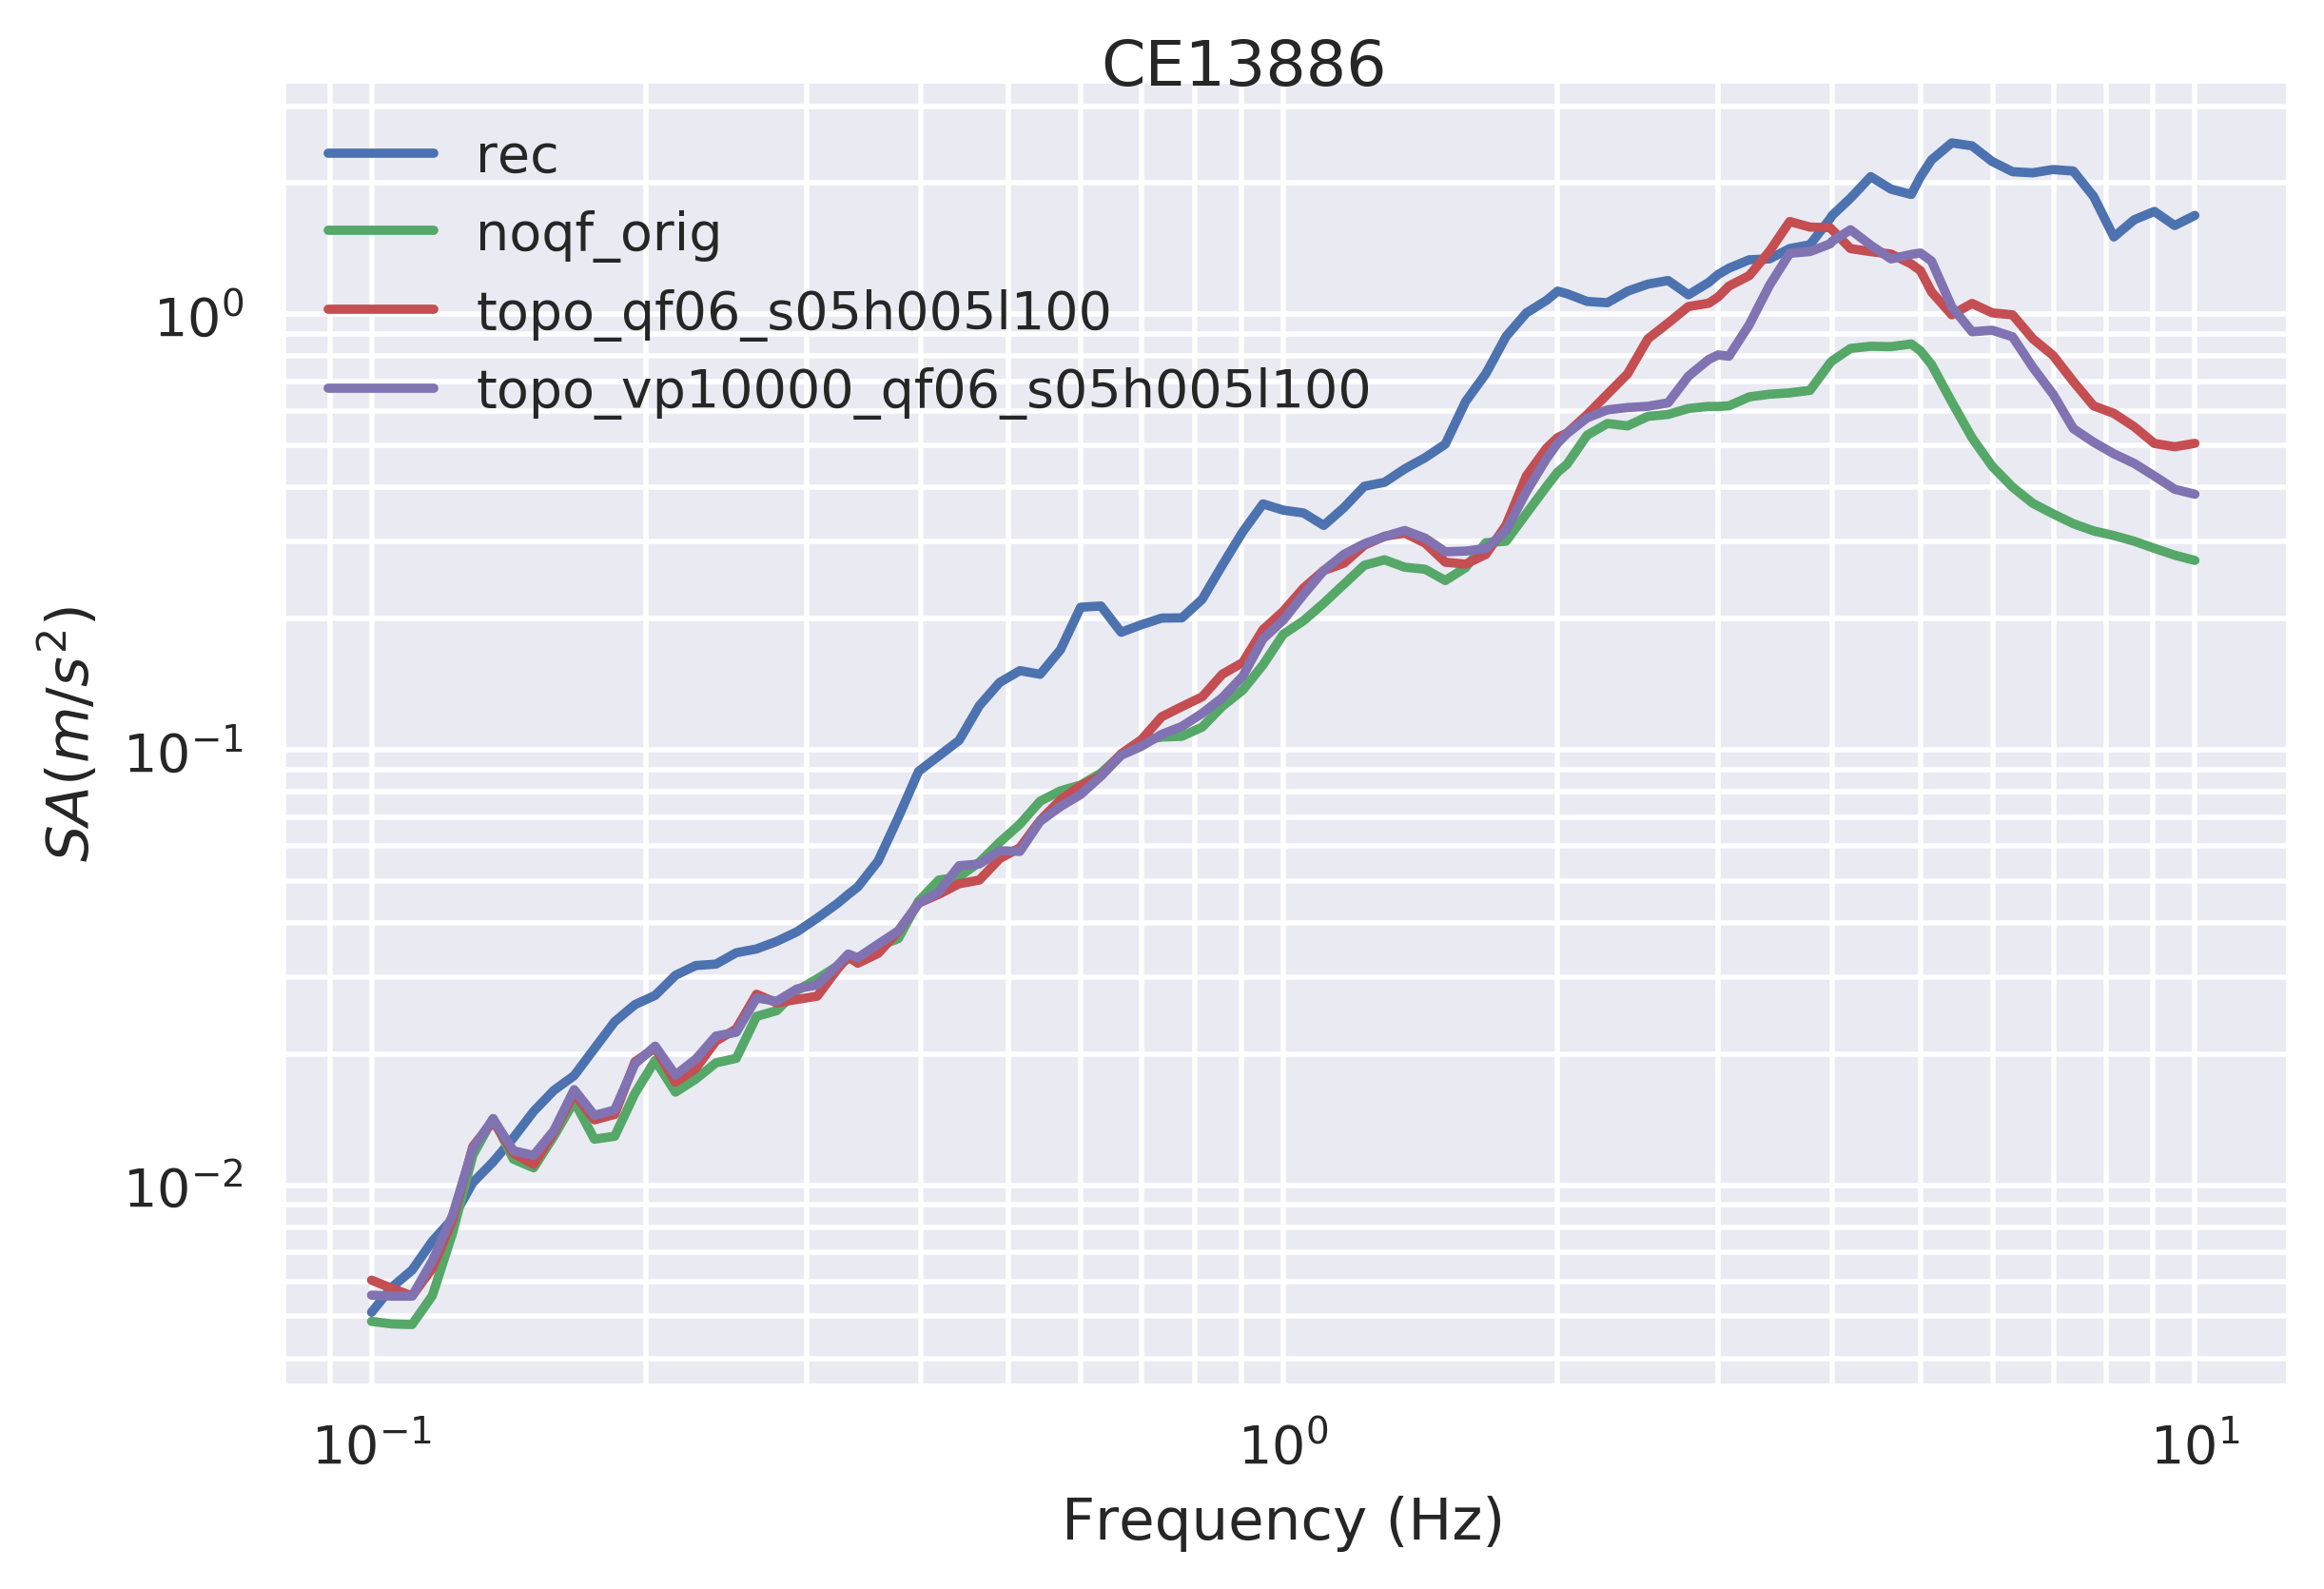

In [45]:
models = ["noqf_orig", "qf06_orig", "qf06_s05h005l100", "topo_qf06_s05h005l100"]
models = ["noqf_orig", "topo_qf06_s05h005l100", "topo_vp10000_qf06_s05h005l100"]
image = plot_validation(9, models, shift=20, highcut=0.3, metrics=['vel', 'psa'])


### Q(f)

(10, 20)

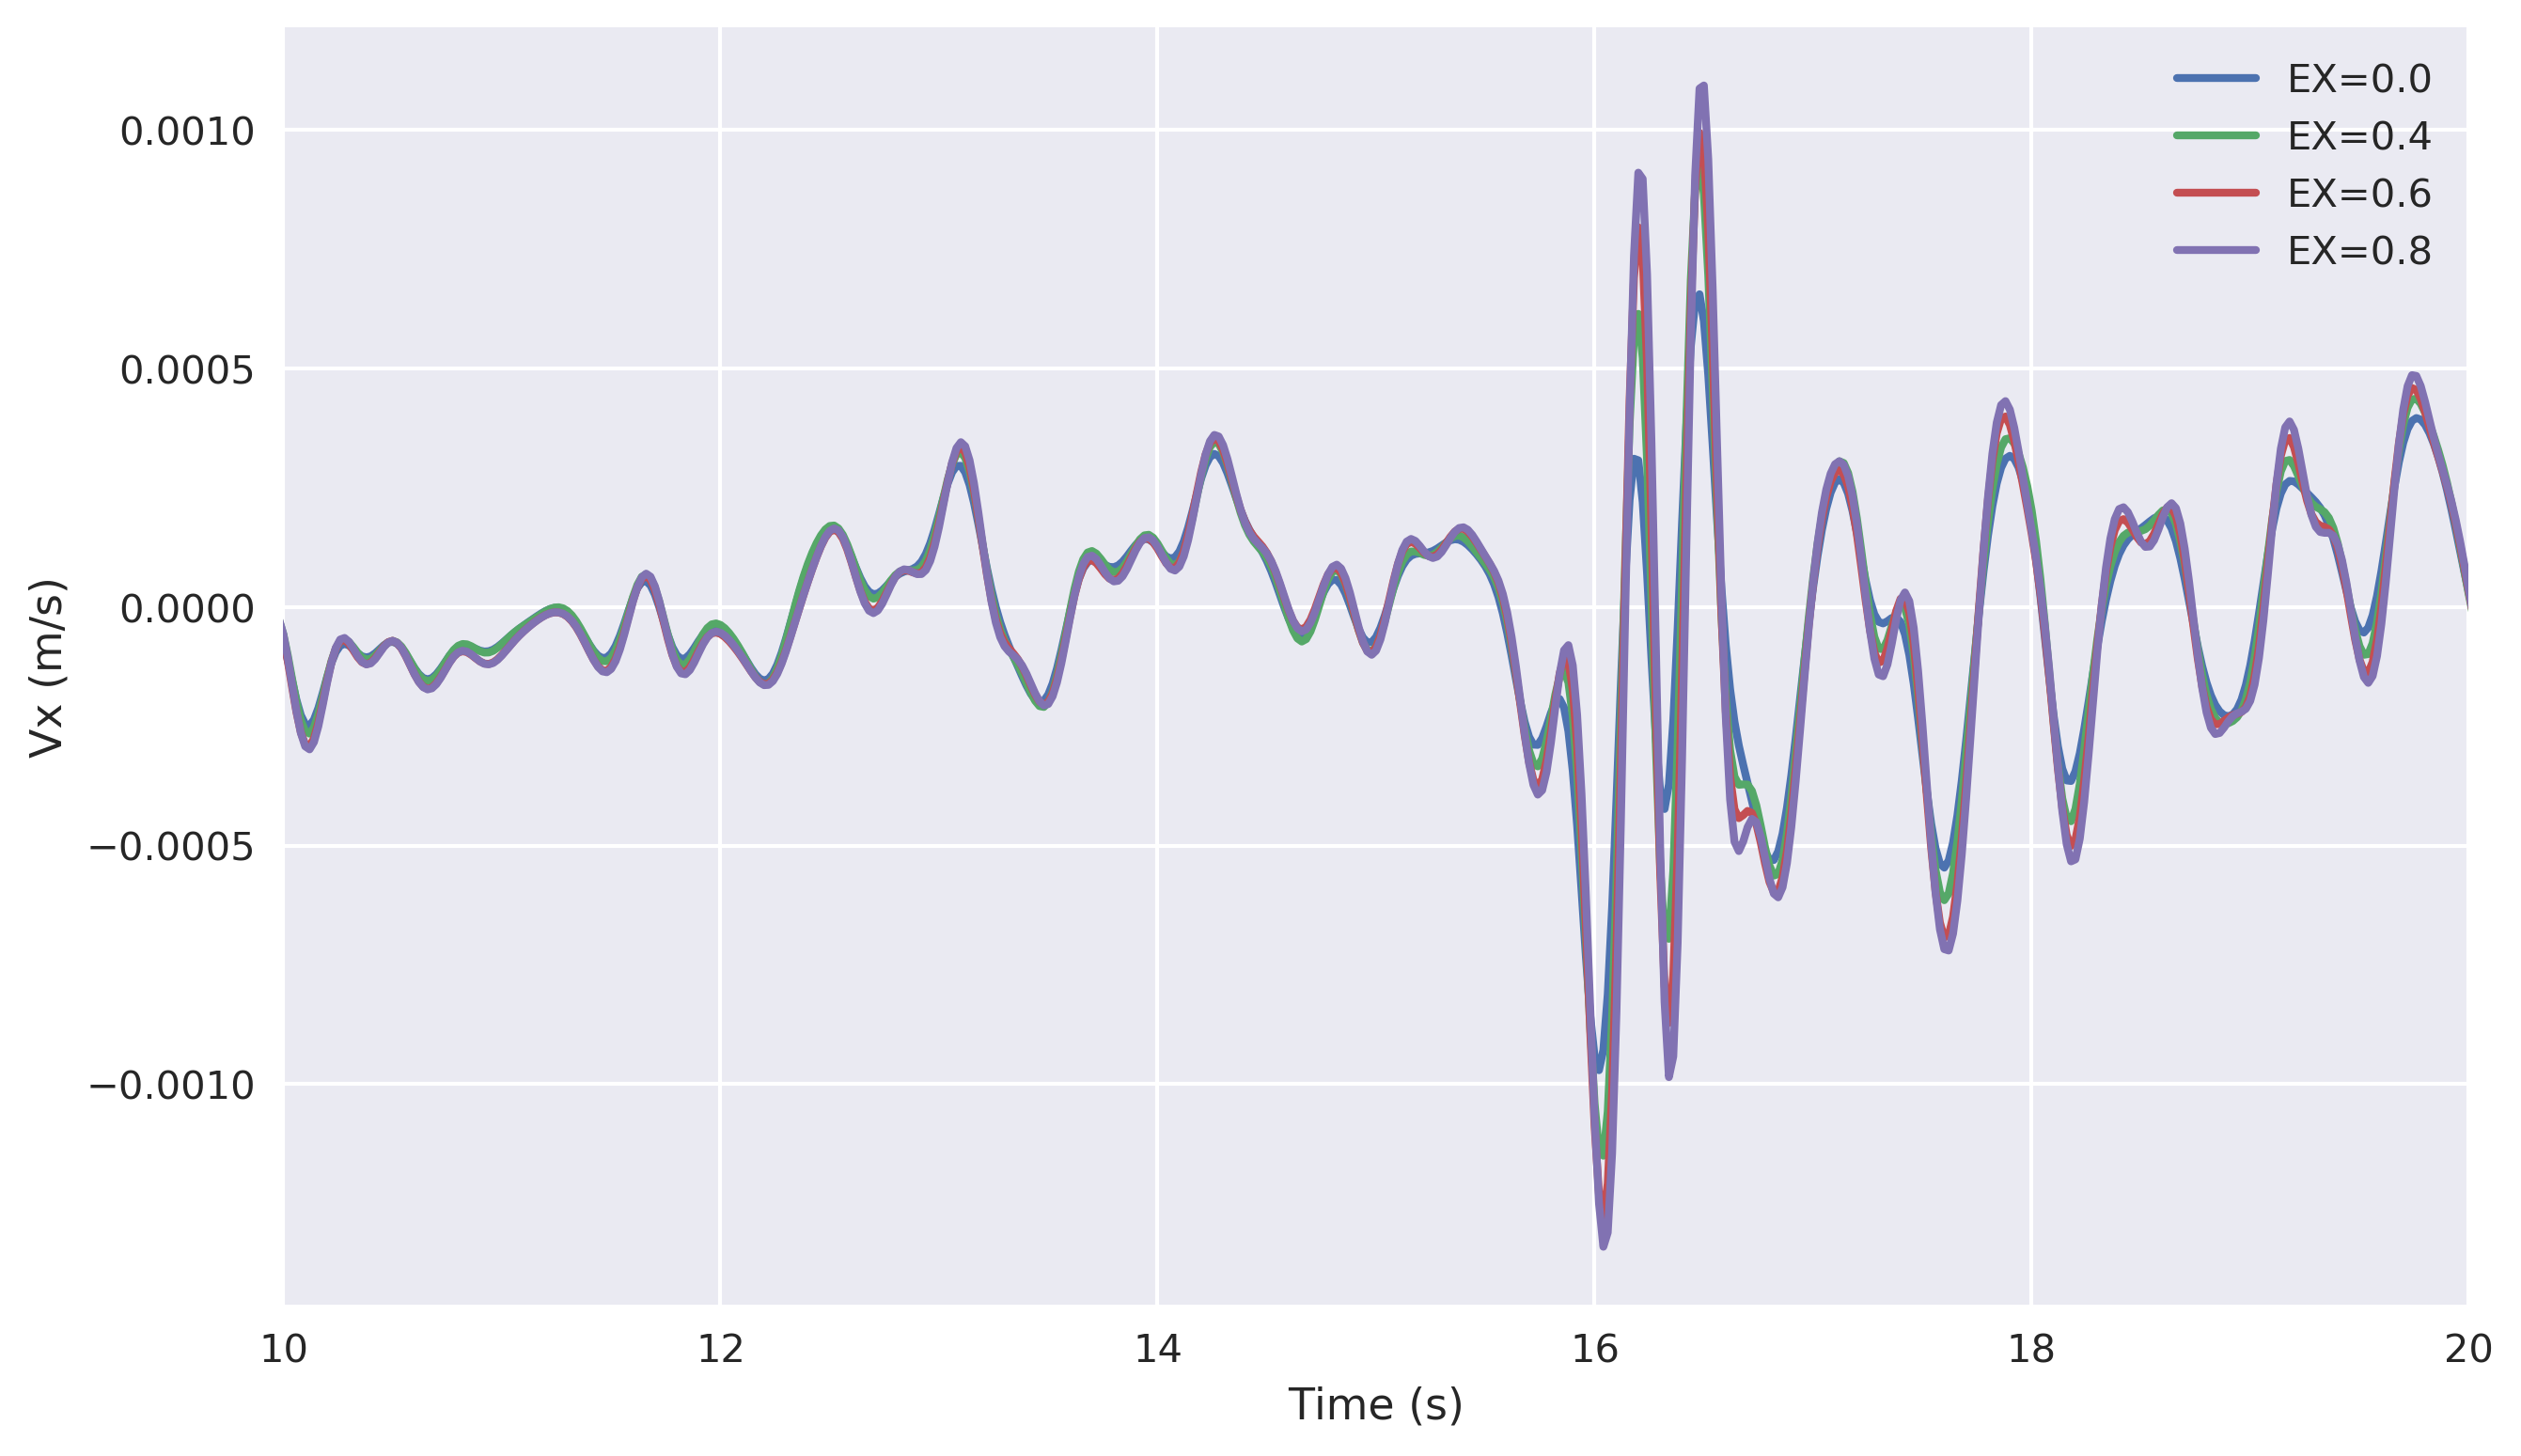

In [41]:
fig, ax = plt.subplots(figsize=(10, 6)) 
ax.plot(np.arange(nt) * dt, syn["noqf_orig"], lw=2, label='EX=0.0')
ax.plot(np.arange(nt) * dt, syn["qf04_orig"], lw=2, label='EX=0.4')
ax.plot(np.arange(nt) * dt, syn["qf06_orig"], lw=2, label='EX=0.6')
ax.plot(np.arange(nt) * dt, syn["qf08_orig"], lw=2, label='EX=0.8')
#ax.plot(np.arange(nt) * dt, syn["qf06_h005l100"], lw=1, label='EX=0.6, h005l100')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vx (m/s)')
ax.legend()
ax.set_xlim([10, 20])
#ax.set_ylim([-10, 10])

(15, 20)

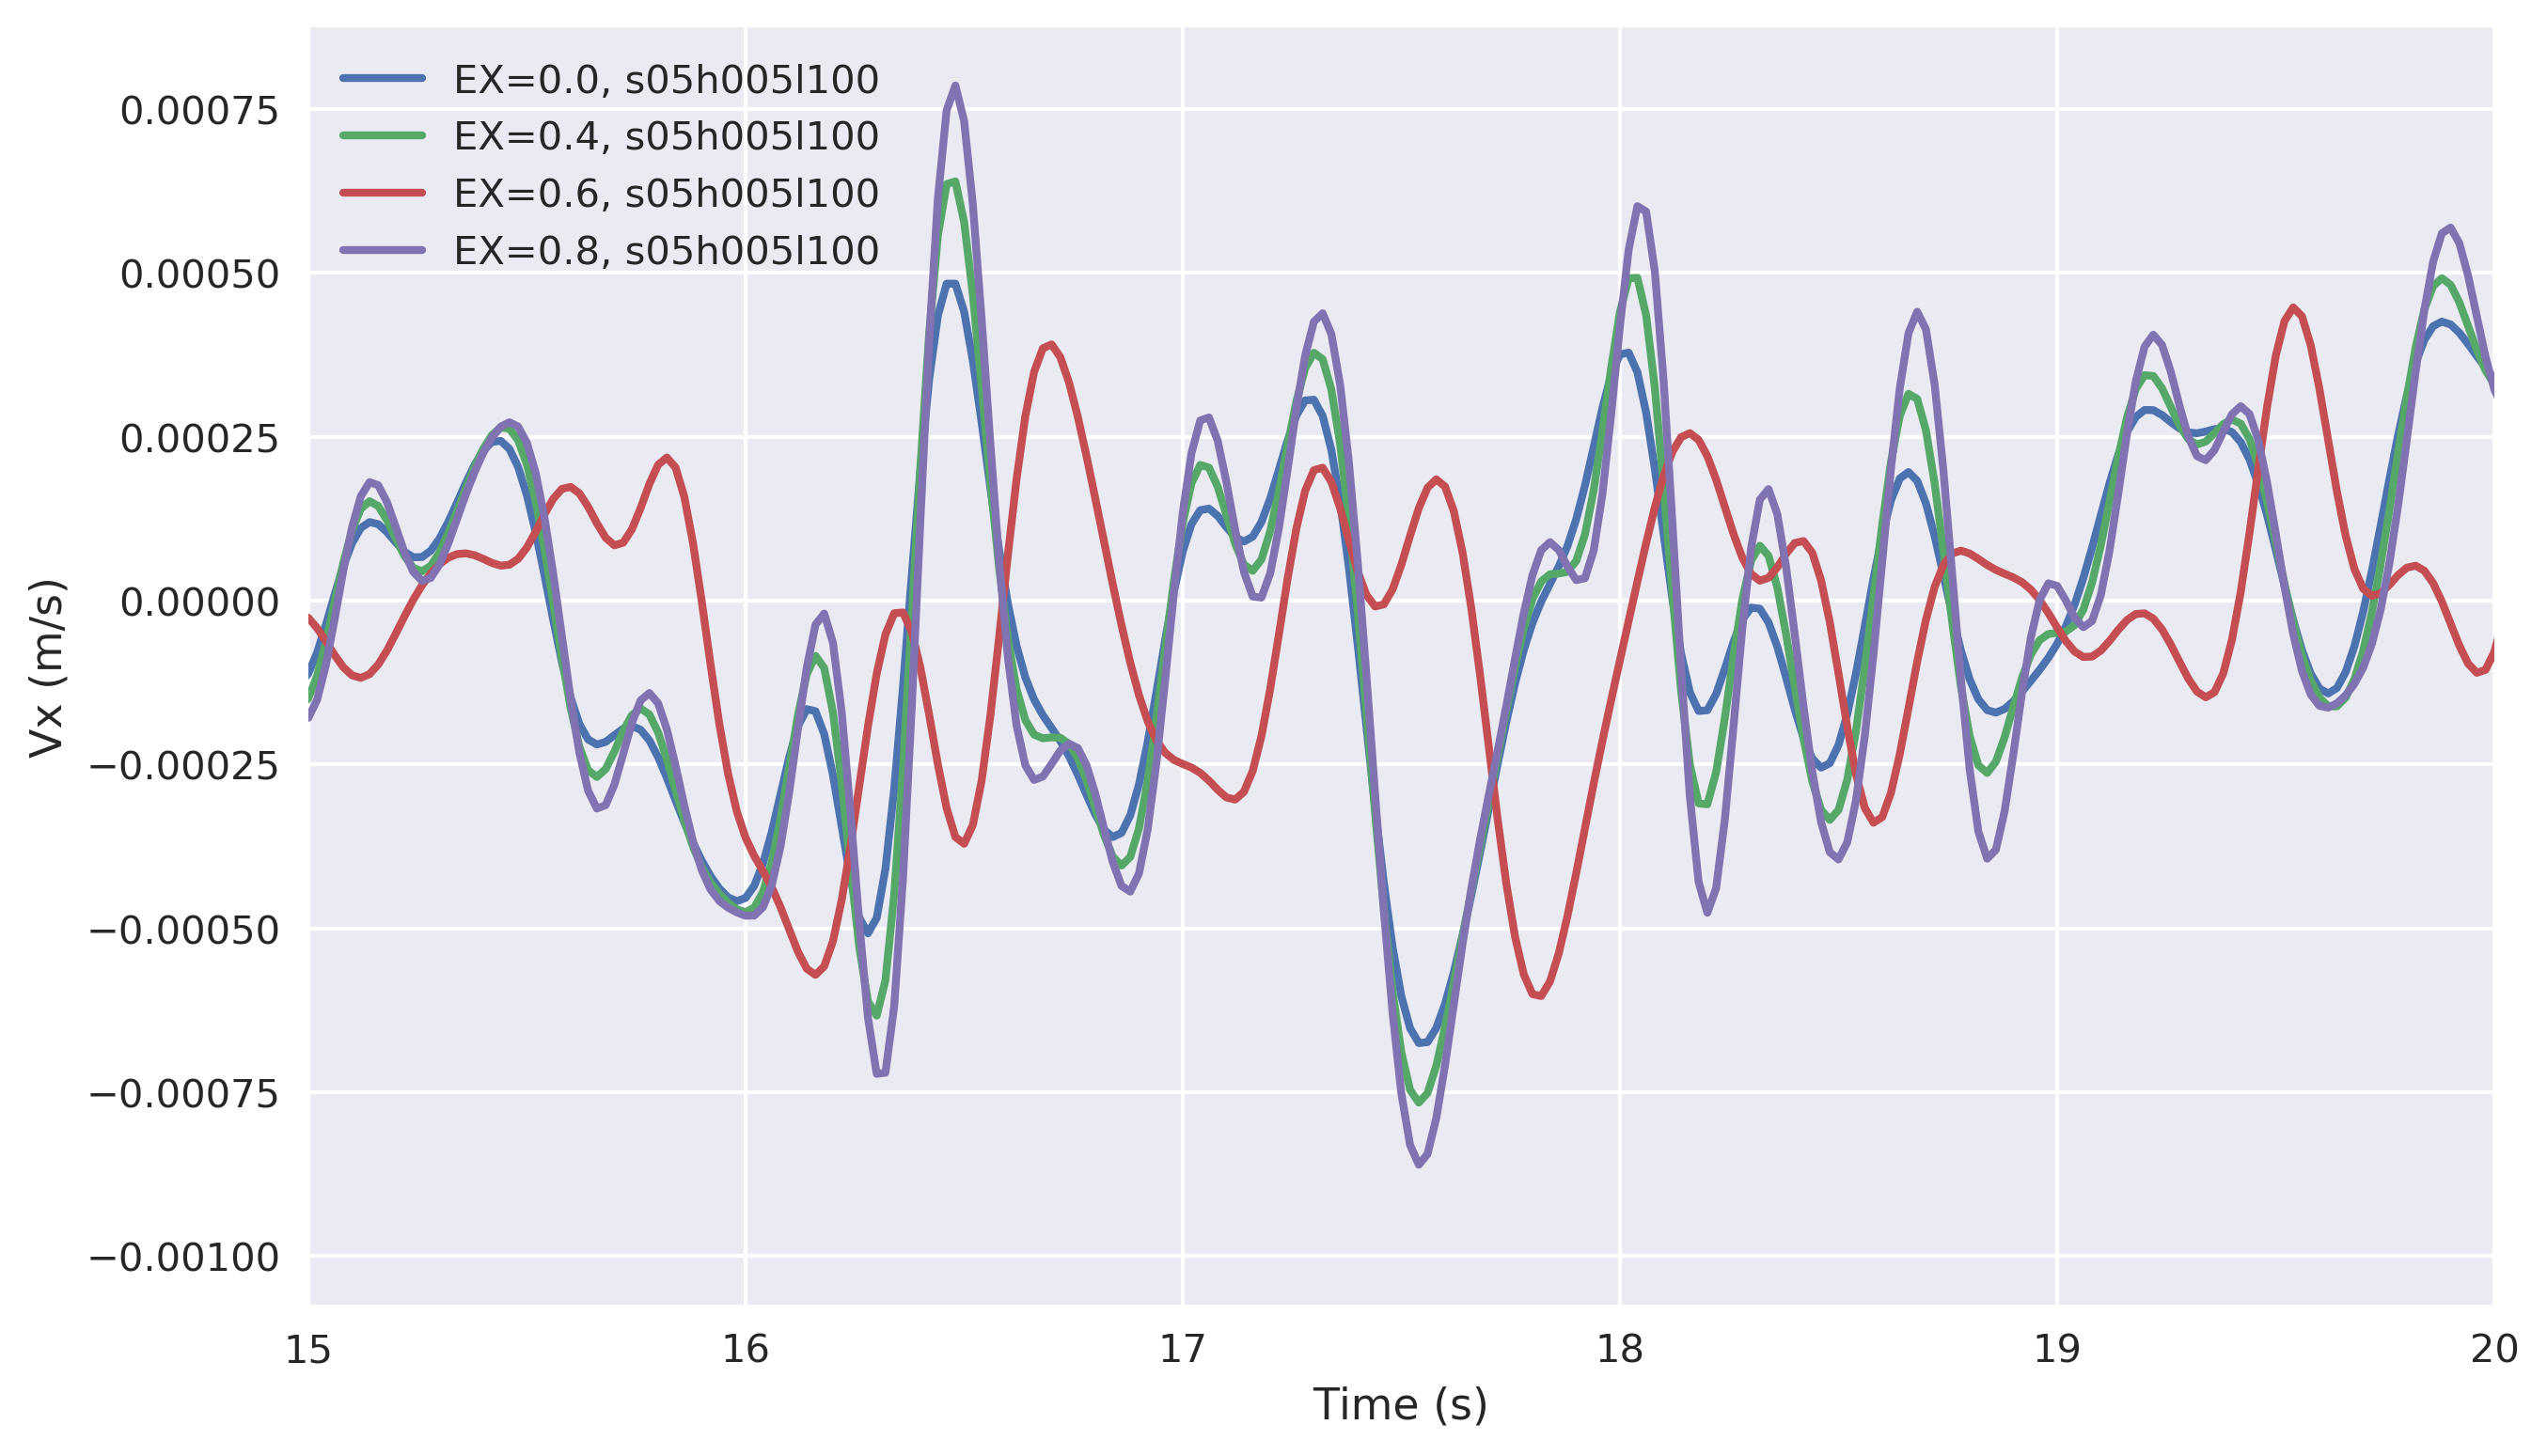

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(nt) * dt, syn["noqf_s05h005l100"], lw=2, label='EX=0.0, s05h005l100')
ax.plot(np.arange(nt) * dt, syn["qf04_s05h005l100"], lw=2, label='EX=0.4, s05h005l100')
ax.plot(np.arange(nt) * dt, syn["qf06_s05h005l100"], lw=2, label='EX=0.6, s05h005l100')
ax.plot(np.arange(nt) * dt, syn["qf08_s05h005l100"], lw=2, label='EX=0.8, s05h005l100')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vx (m/s)')
ax.legend()
ax.set_xlim([15, 20])
#ax.set_ylim([-10, 10])

(15, 20)

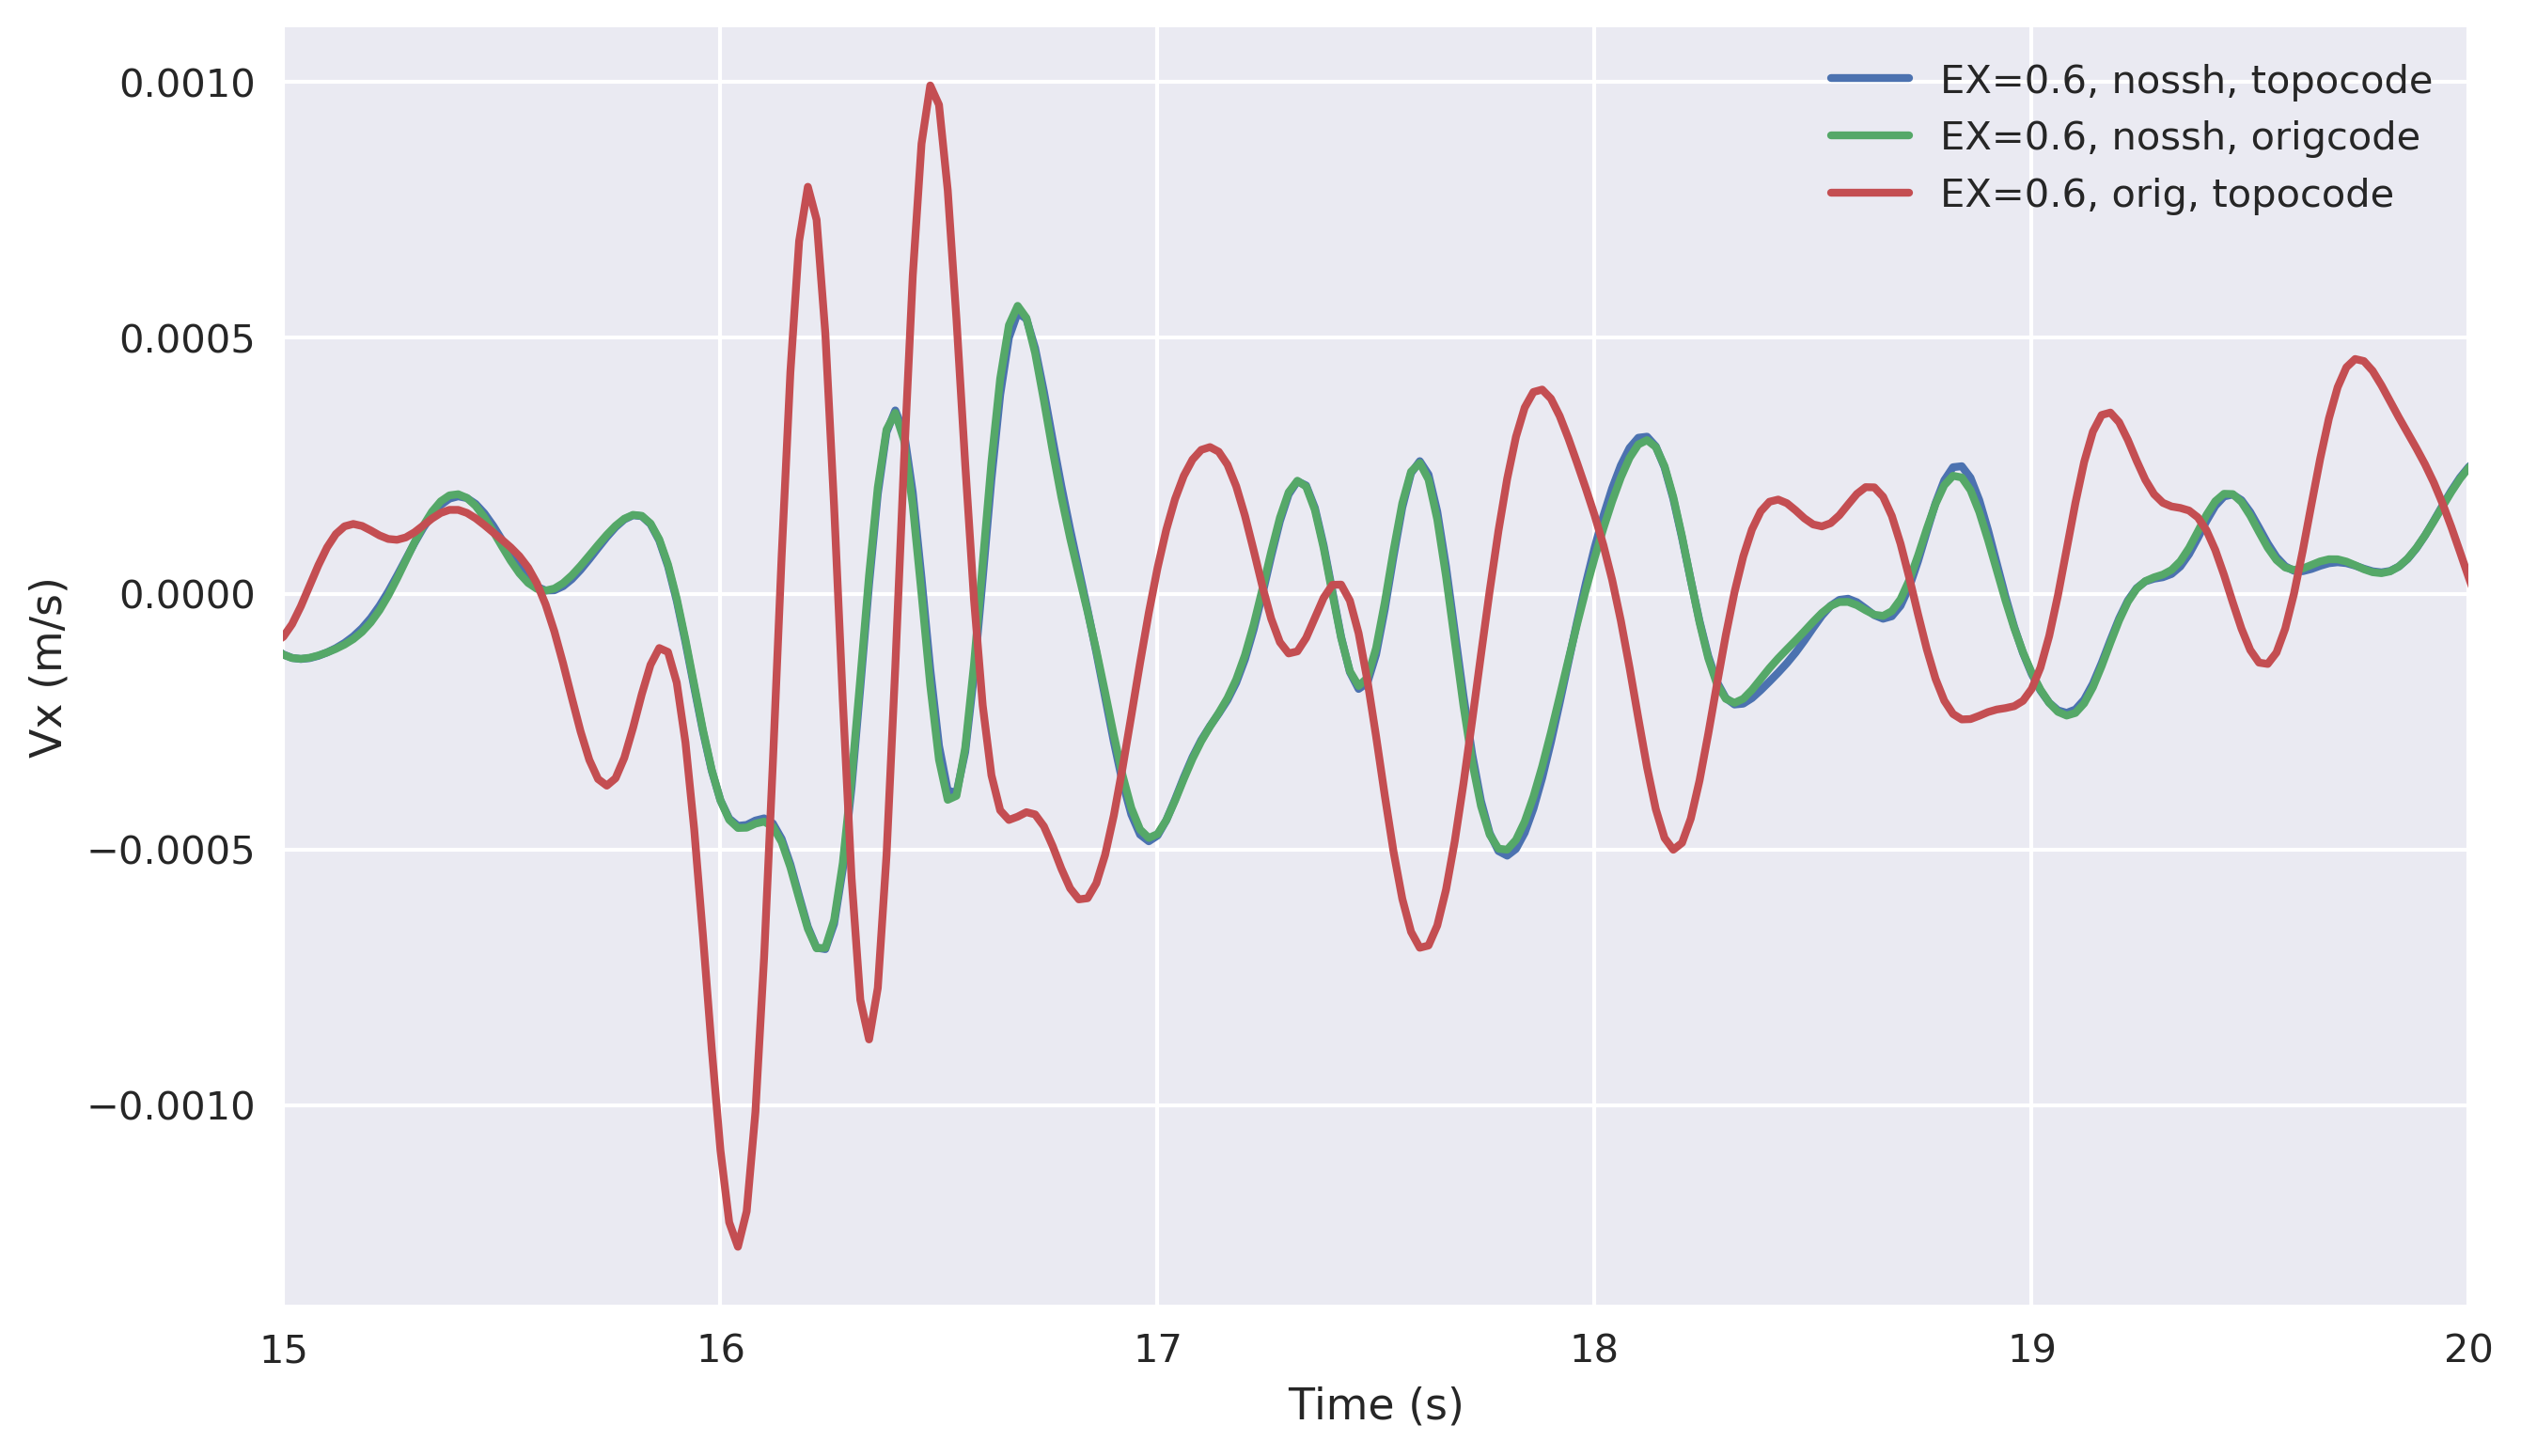

In [77]:
#ix = np.random.randint(mx)
#iy = np.random.randint(my)

#syn["toy_topo"] = read_syn(ix, iy, highcut=4, model="toy", case="orig_topocode")
#syn["toy_orig"] = read_syn(ix, iy, highcut=4, model="toy", case="orig_origcode")
#syn["qf06_orig"] = read_syn(ix, iy, highcut=4, model="qf04_orig") 
#syn["qf06_s05h005l100"] = read_syn(ix, iy, highcut=4, model="qf06_s05h005l100")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(nt) * dt, syn["toy_topo"], lw=2, label='EX=0.6, nossh, topocode')
ax.plot(np.arange(nt) * dt, syn["toy_orig"], lw=2, label='EX=0.6, nossh, origcode')
ax.plot(np.arange(nt) * dt, syn["qf06_orig"], lw=2, label='EX=0.6, orig, topocode')

#ax.plot(np.arange(nt) * dt, syn["qf06_s05h005l100"], lw=1, label='EX=0.6, ssh, origcode')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vx (m/s)')
ax.legend()
ax.set_xlim([15, 20])
#ax.set_ylim([-0.001, 0.001])

### Correlation length

(15, 25)

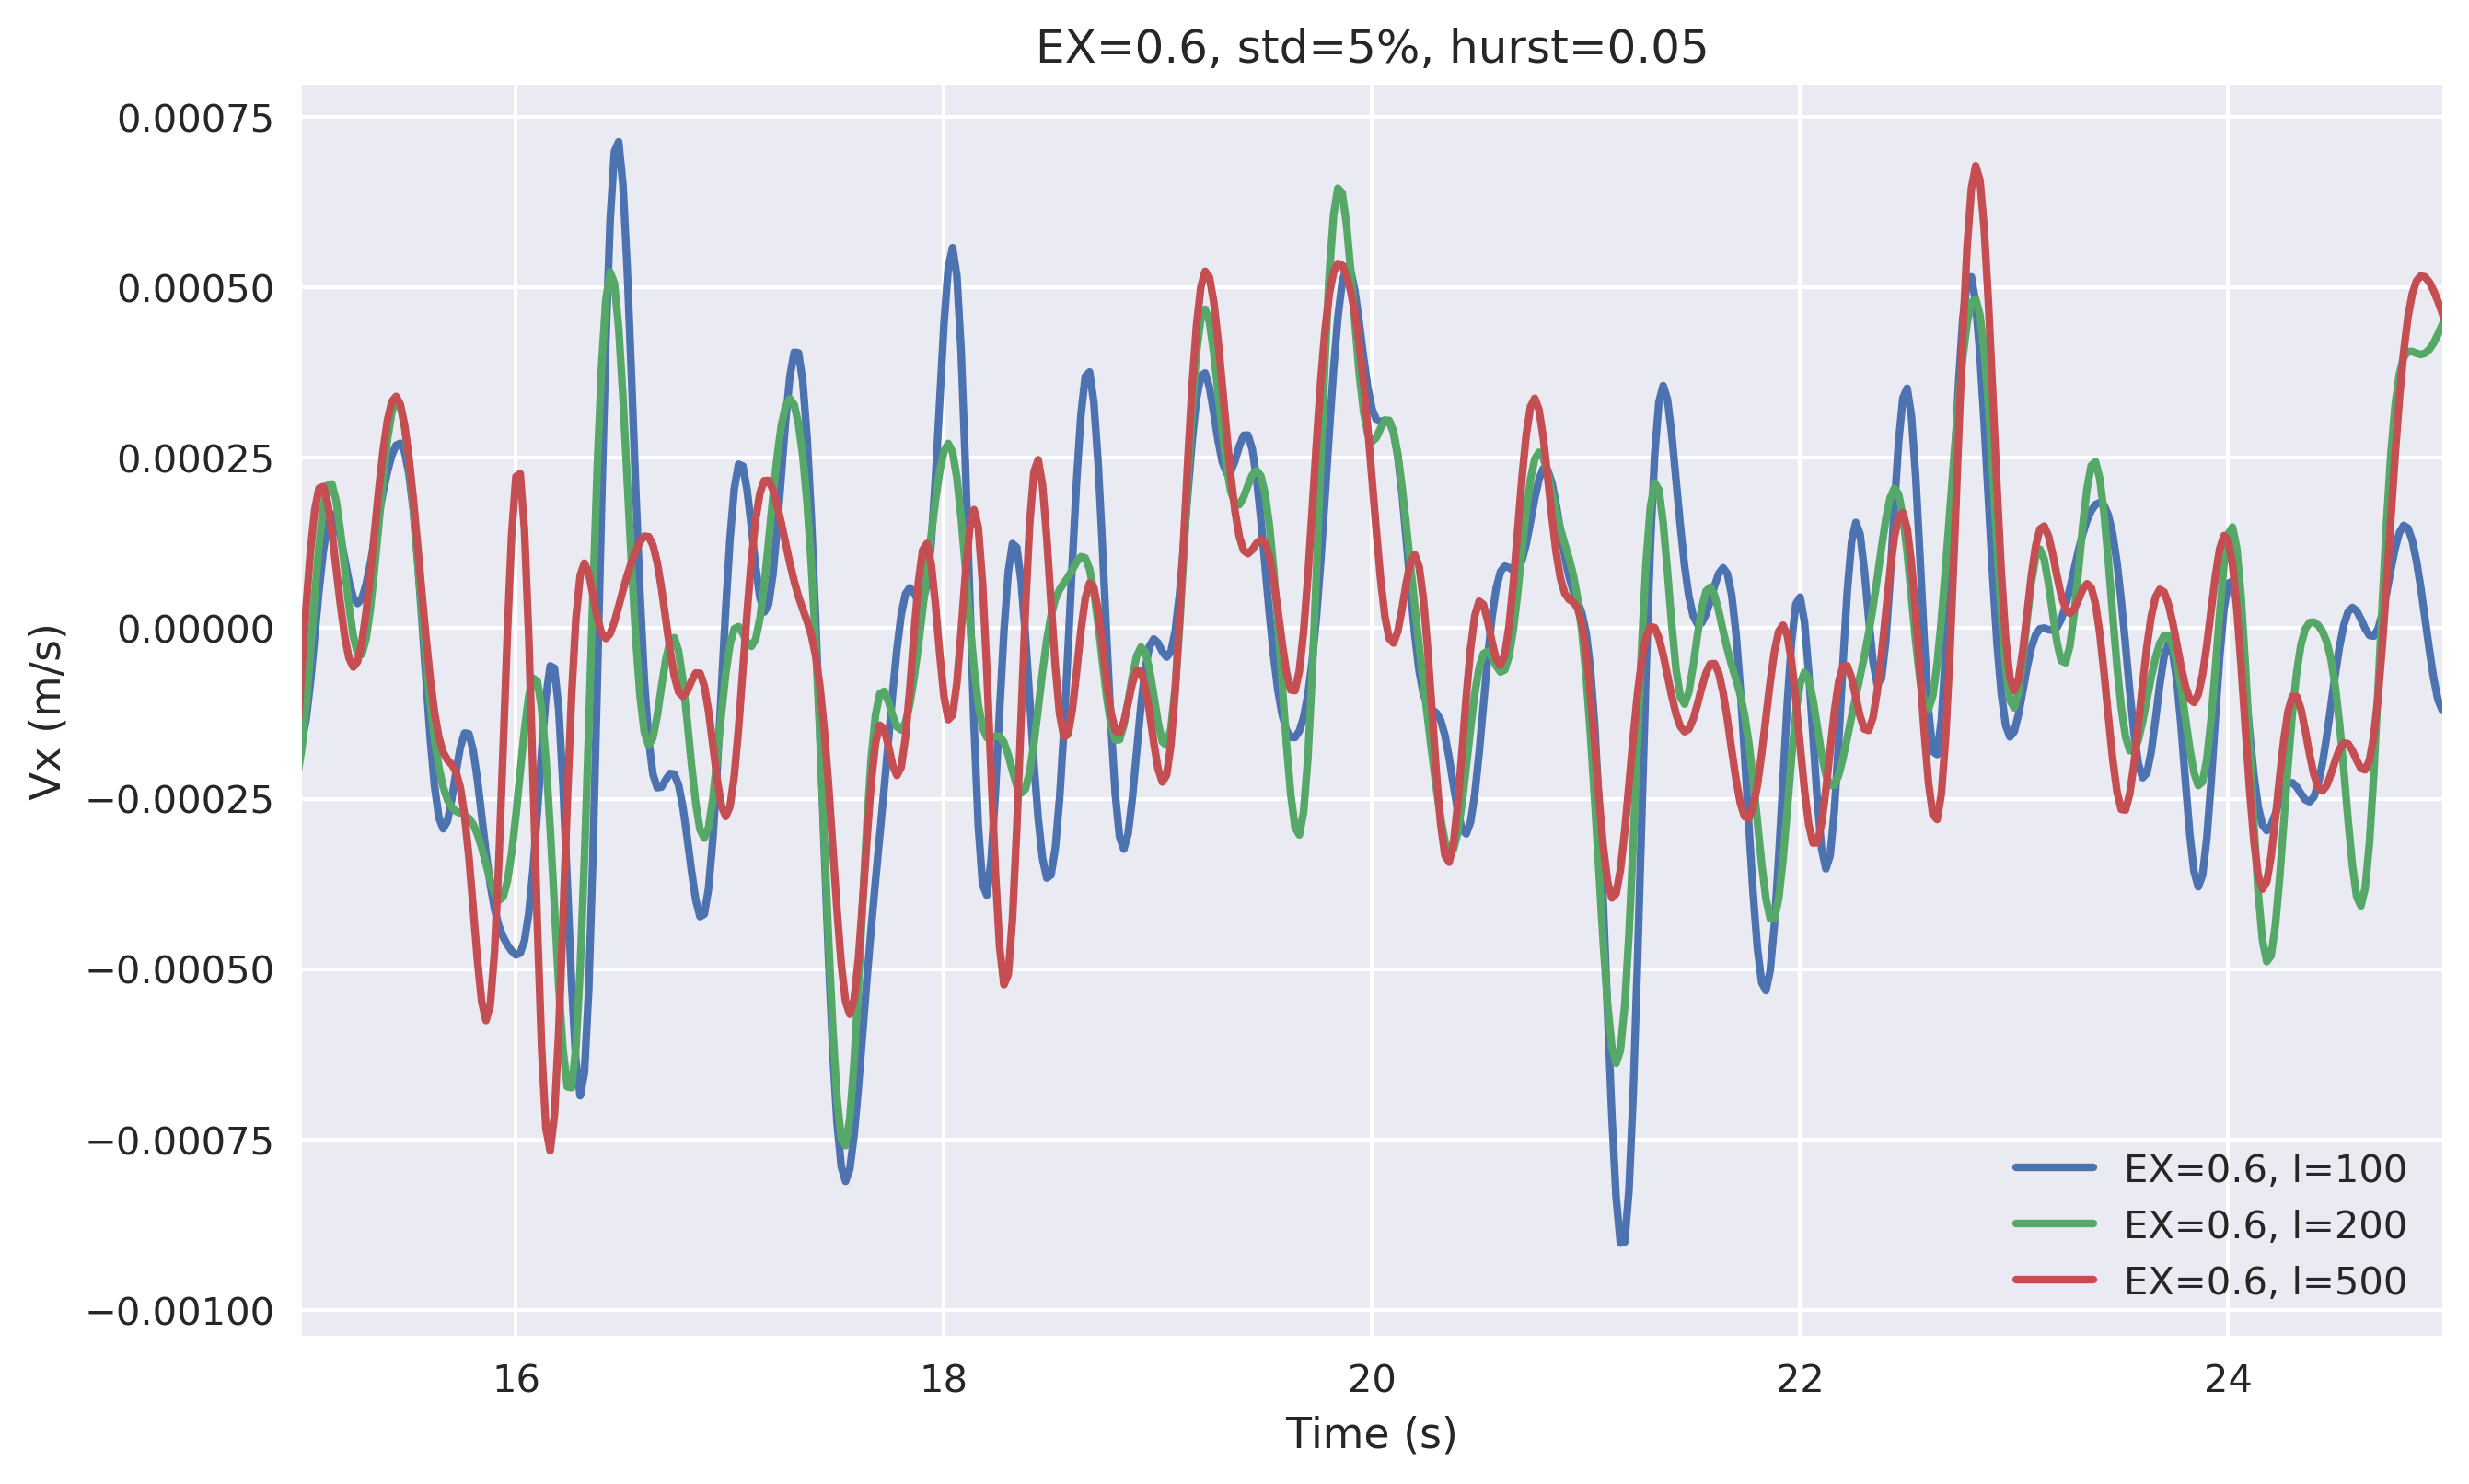

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(nt) * dt, syn["qf06_s05h005l100"], lw=2, label='EX=0.6, l=100')
ax.plot(np.arange(nt) * dt, syn["qf06_s05h005l200"], lw=2, label='EX=0.6, l=200')
ax.plot(np.arange(nt) * dt, syn["qf06_s05h005l500"], lw=2, label='EX=0.6, l=500')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vx (m/s)')
ax.legend()
ax.set_title('EX=0.6, std=5%, hurst=0.05')
ax.set_xlim([15, 25])
#ax.set_ylim([-10, 10])

### Hurst number
ALmost no effects

(15, 25)

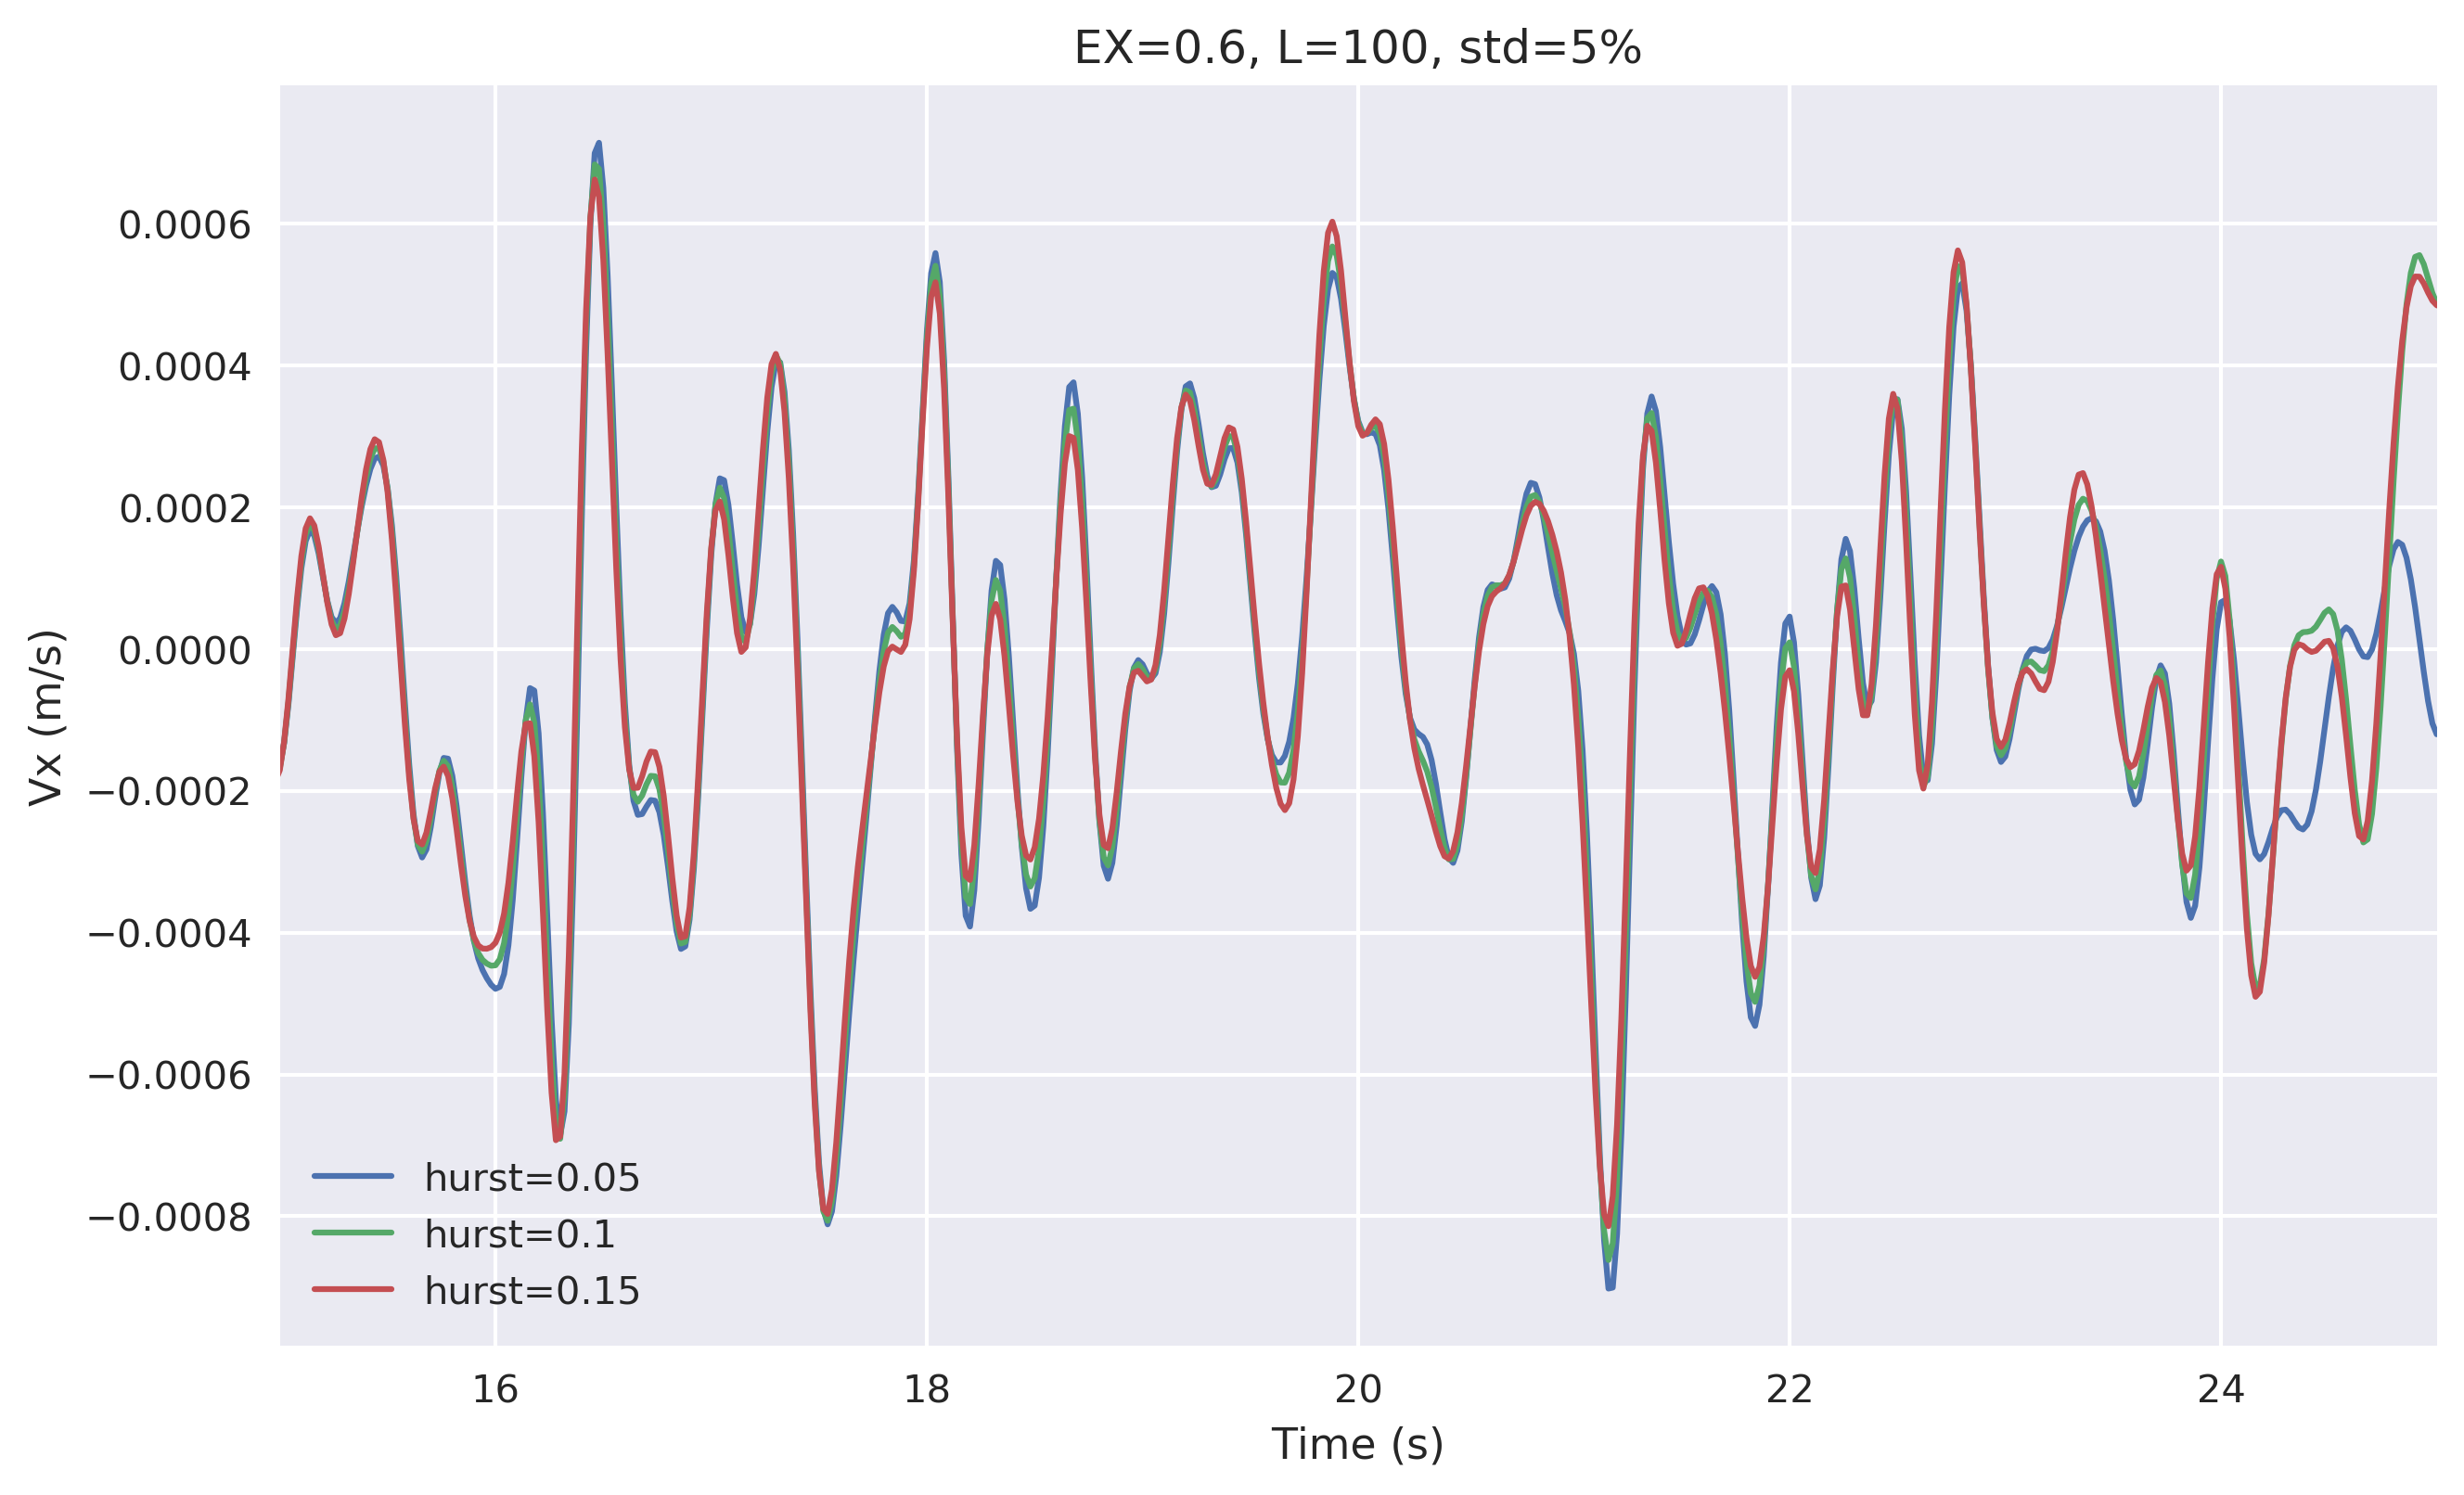

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(nt) * dt, syn["qf06_s05h005l100"], lw=1.5, label='hurst=0.05')
ax.plot(np.arange(nt) * dt, syn["qf06_s05h010l100"], lw=1.5, label='hurst=0.1')
ax.plot(np.arange(nt) * dt, syn["qf06_s05h015l100"], lw=1.5, label='hurst=0.15')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Vx (m/s)')
ax.legend()
ax.set_title('EX=0.6, L=100, std=5%')
ax.set_xlim([15, 25])
#ax.set_ylim([-10, 10])

### Standard deviation

qf06_s05h005l100/output_sfc/SX_0_0030000


(15, 25)

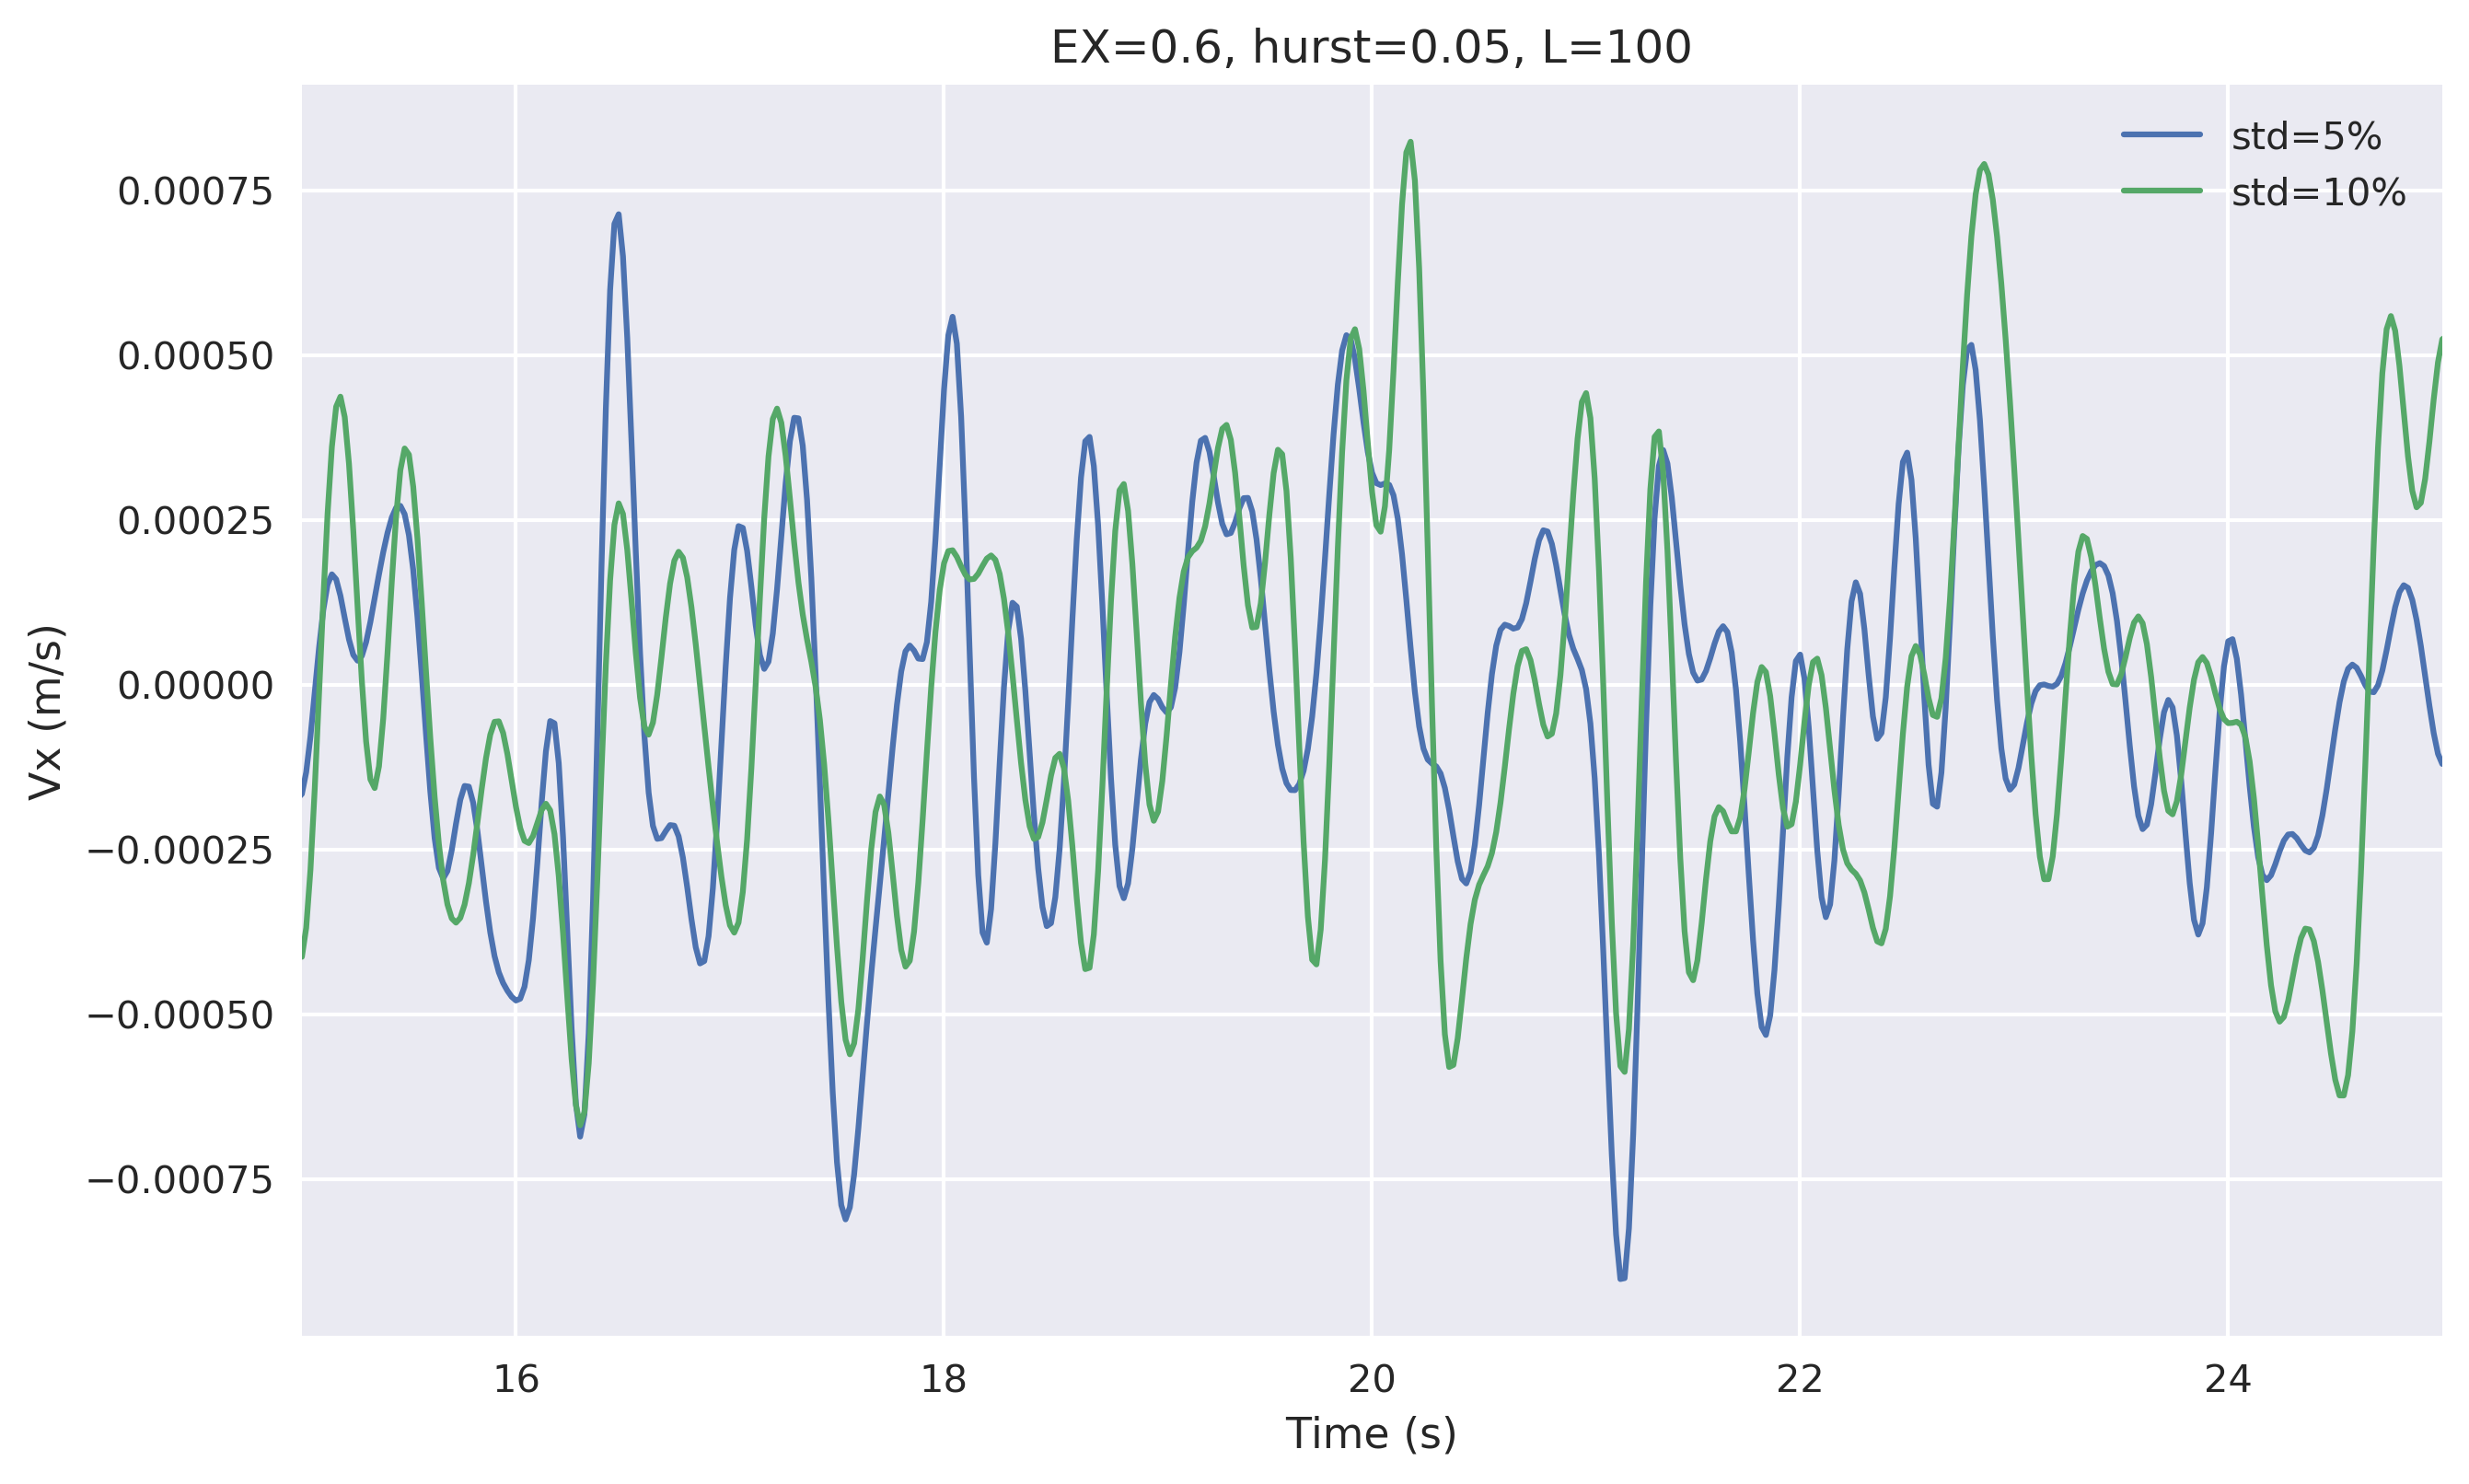

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(nt) * dt, syn["qf06_s05h005l100"], lw=1.5, label='std=5%')
ax.plot(np.arange(nt) * dt, syn["qf06_s10h005l100"], lw=1.5, label='std=10%')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Vx (m/s)')
ax.legend()
ax.set_title('EX=0.6, hurst=0.05, L=100')
ax.set_xlim([15, 25])

## PSA

In [ ]:

accx, accy = (np.diff(x, prepend=0) / dt for x in (velx, vely))                 
sa_pyrotd[i] = my_calc_rotated_spec_accels(dt, accx, accy, [f], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   


## Snapshots

In [116]:
imageio.mimsave('./snapshot.gif', [plot_snapshot(it, model="qf04_s05h005l100") for it in range(0, nt, nt//30)], fps=1)


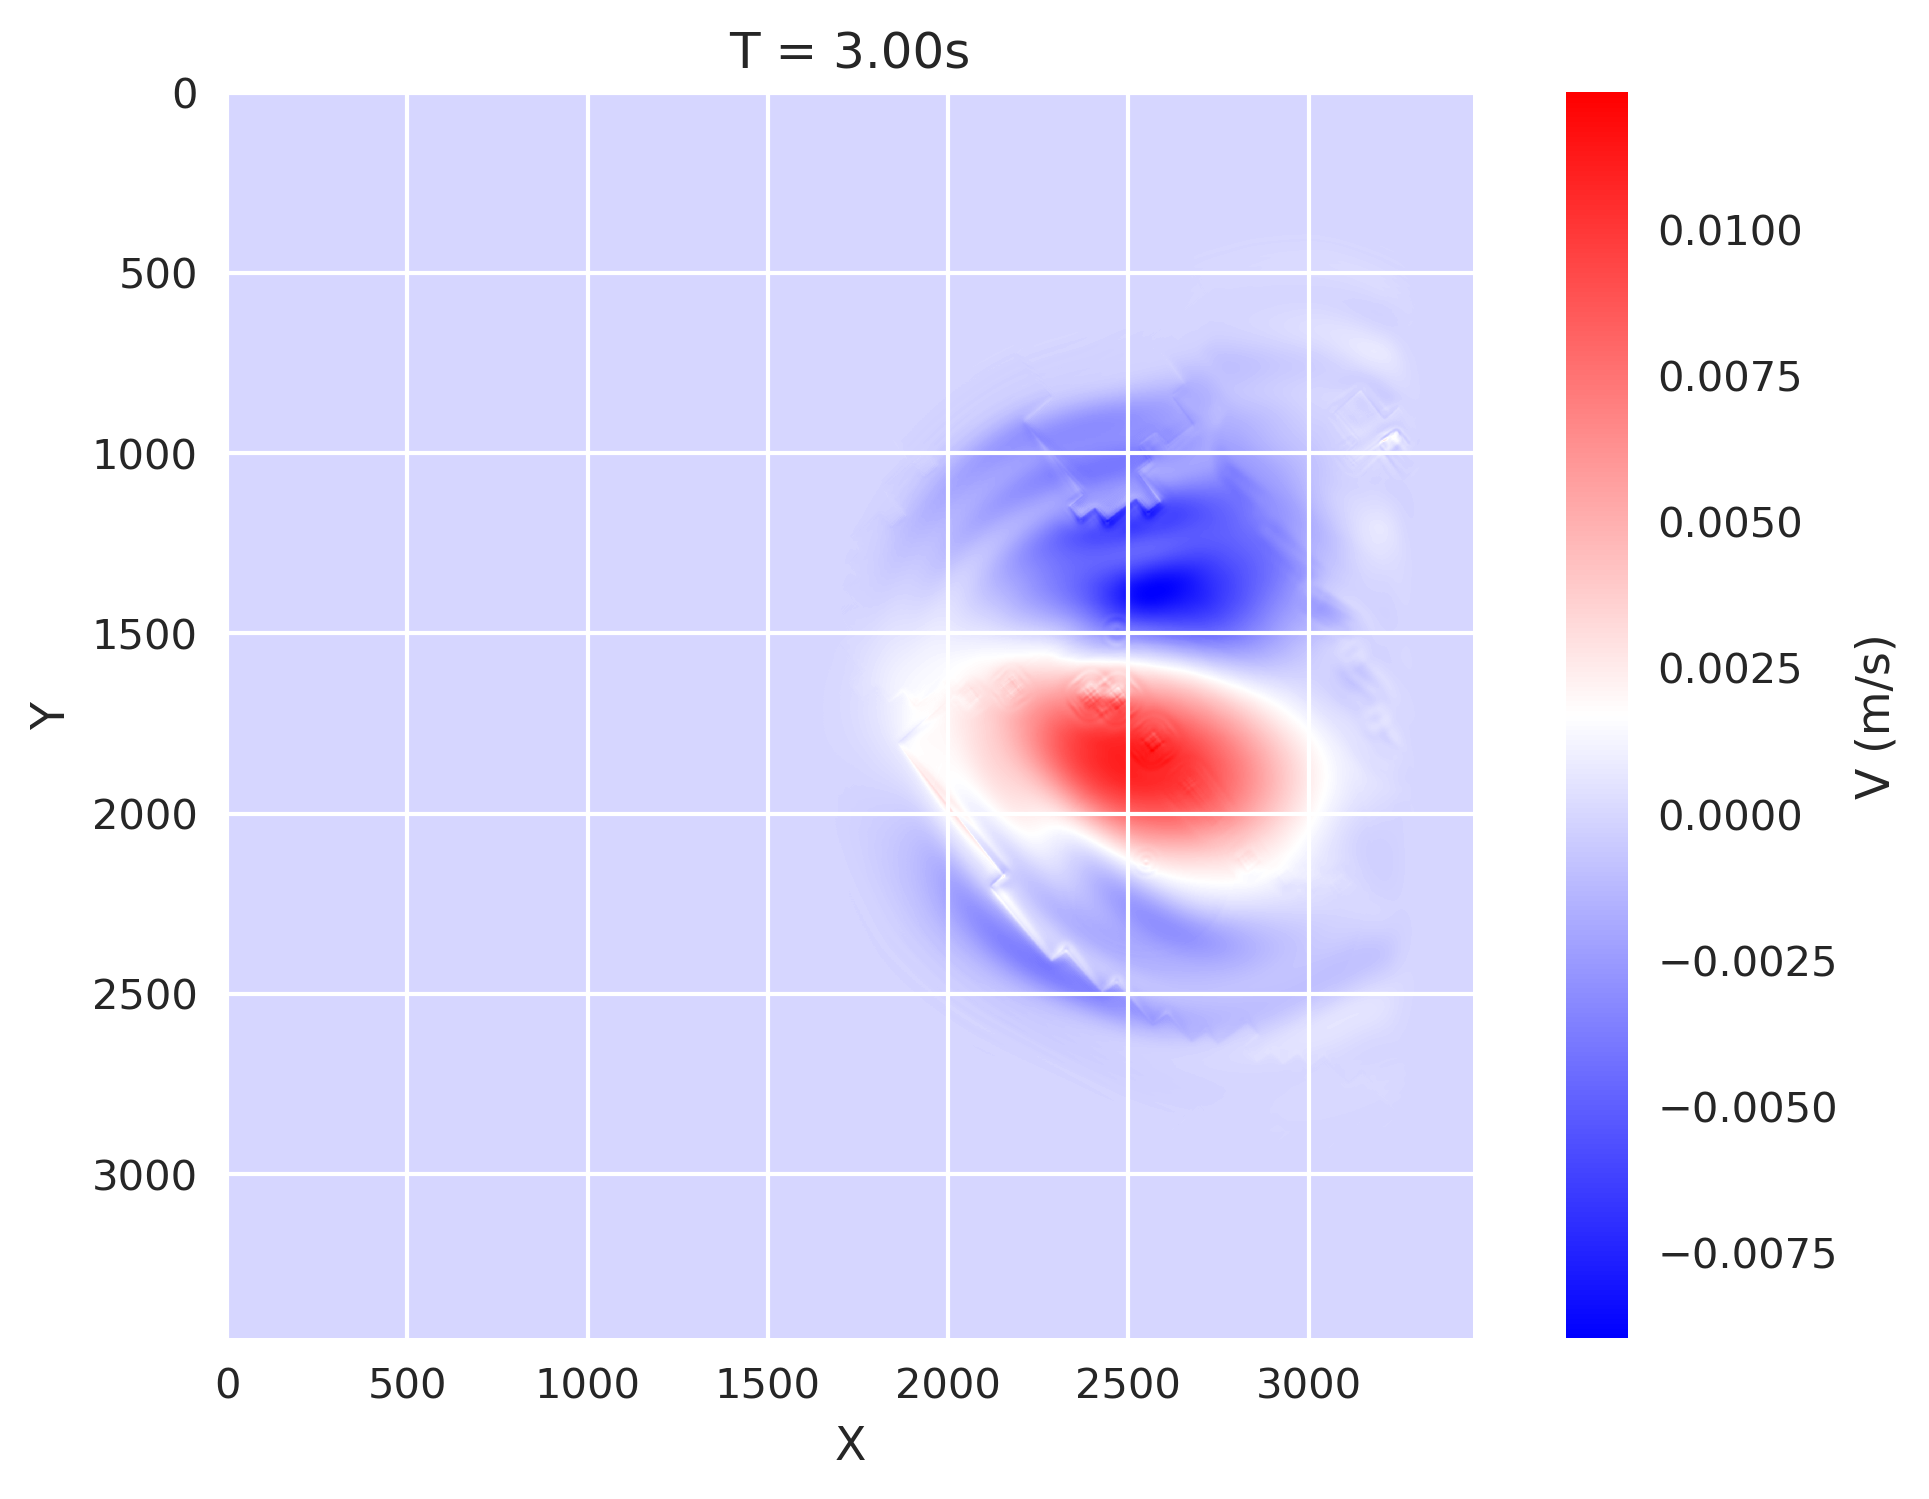

In [81]:
#vx = read_snapshot(it)
it = 150
snap = plot_snapshot(it, model="toy", case="orig_topocode", draw=True)

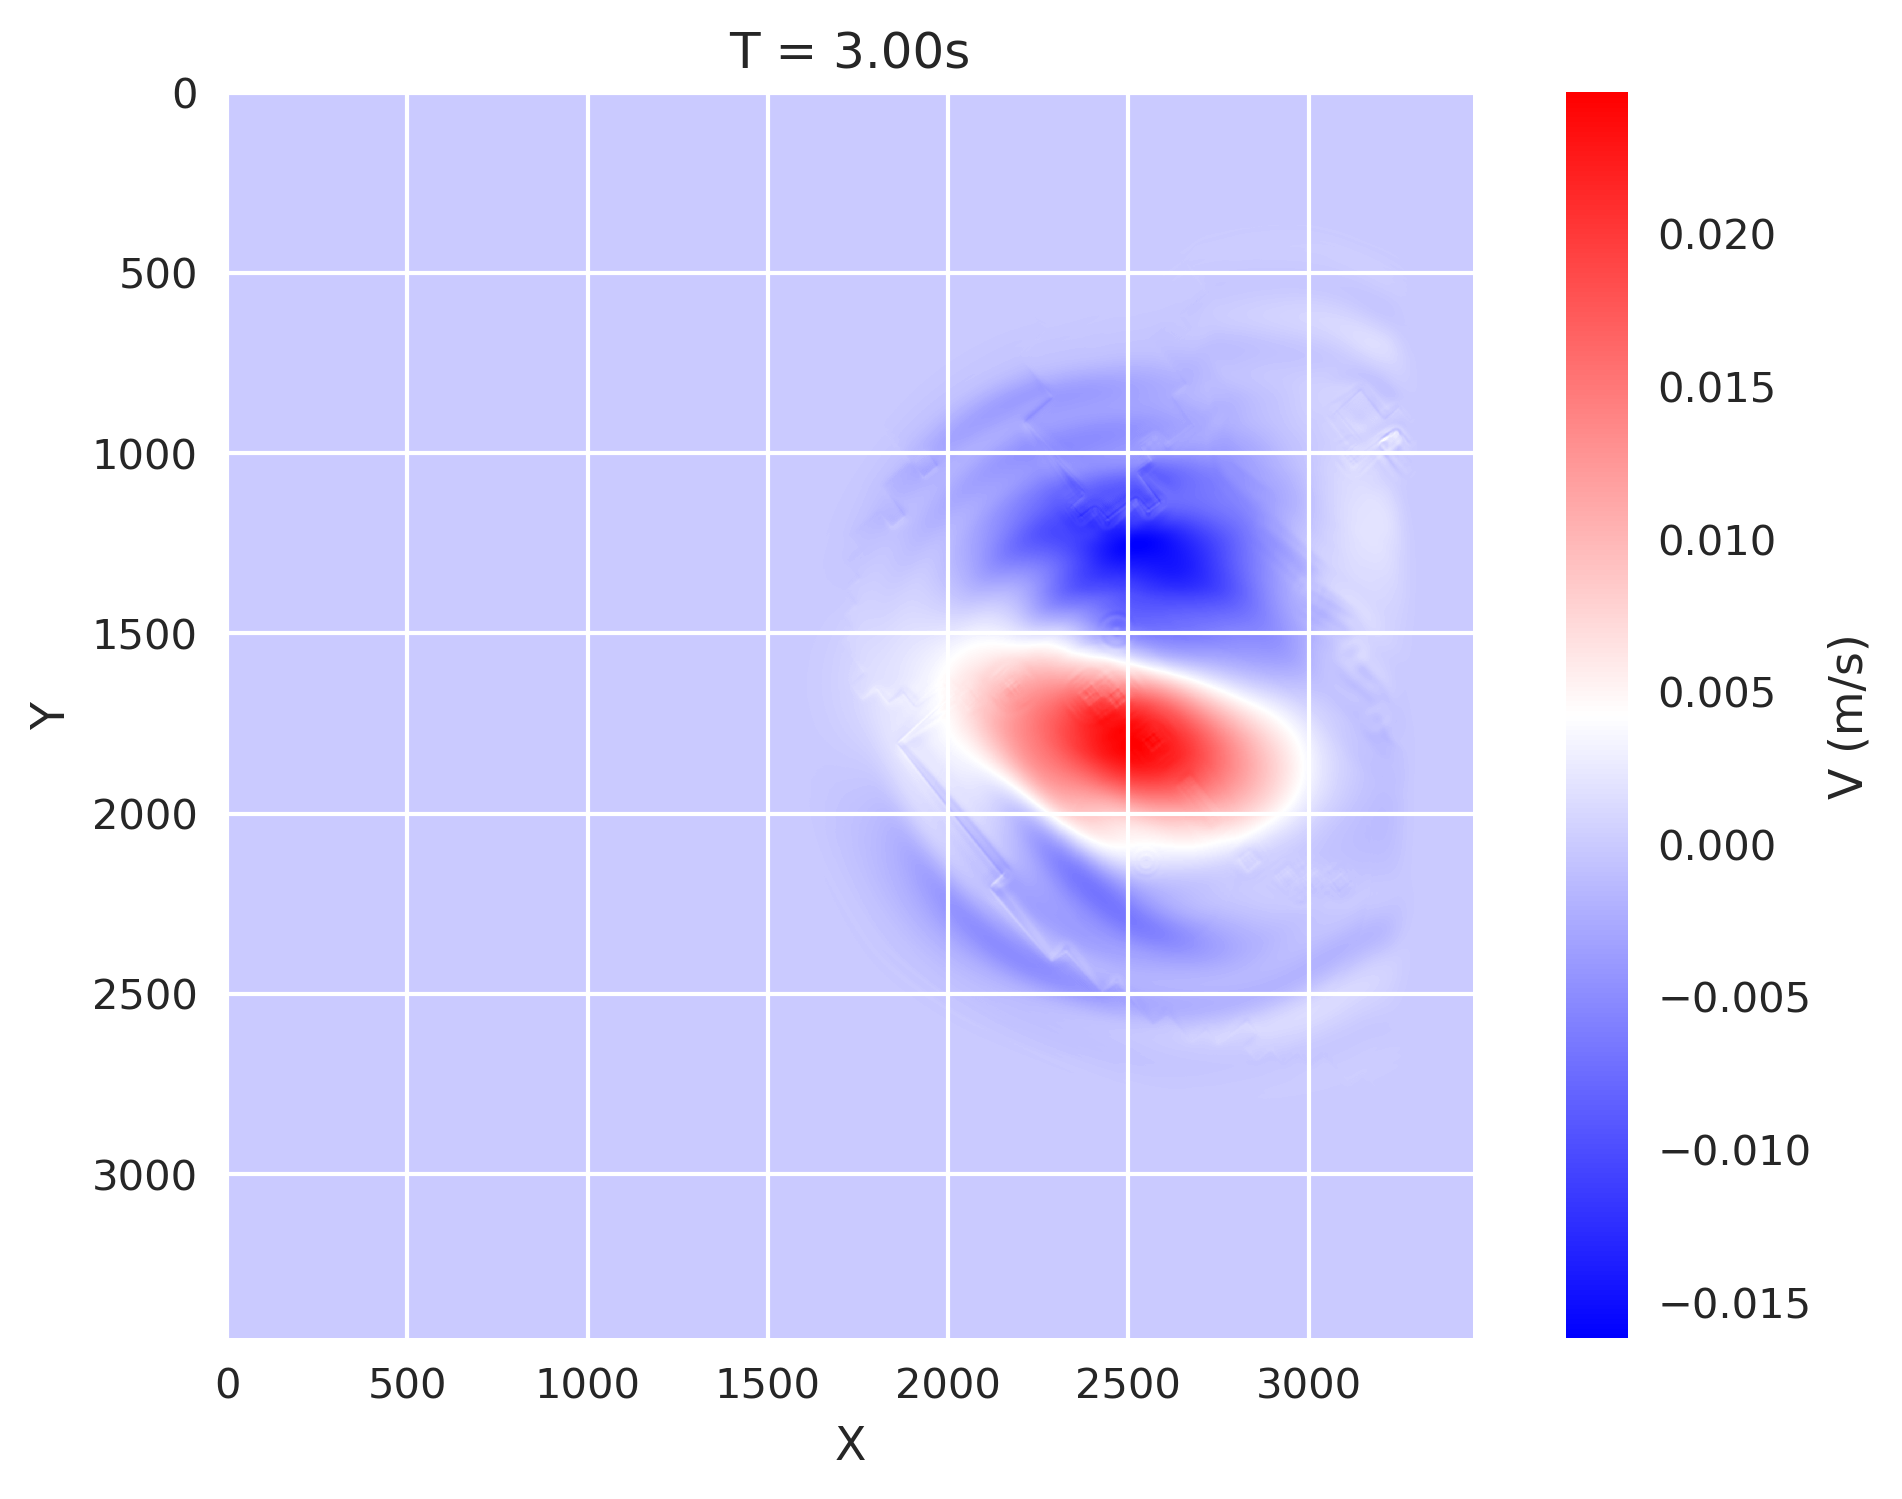

In [82]:
#vx = read_snapshot(it)
it = 150
snap = plot_snapshot(it, model="qf06_orig", draw=True)

In [34]:
#gifpath="snapshot.gif"
#with open(gifpath, 'rb') as fid:
#    display.Image(data=fid.read(), format='png')

## Extra checks

### Source

In [48]:
with open("topo_dt04_qf06_s05h005l100/param.sh") as fid:
    for line in fid:
        params = fid.readline()
        if "TMAX" in params:
            tmax = float(re.findall(r'(?<=TMAX )\d+\.?\d+(?= )', params)[0])
        if "DT" in params:
            dt_upsrc = float(re.findall('(?<=DT )\d+\.?\d+(?= )', params)[0])
            break

30.0
 --TMAX 30.0 --DH 8.0 --DT 0.0004 --ND 80 --ARBC 0.95



5000 999.8000000000001


(0, 10)

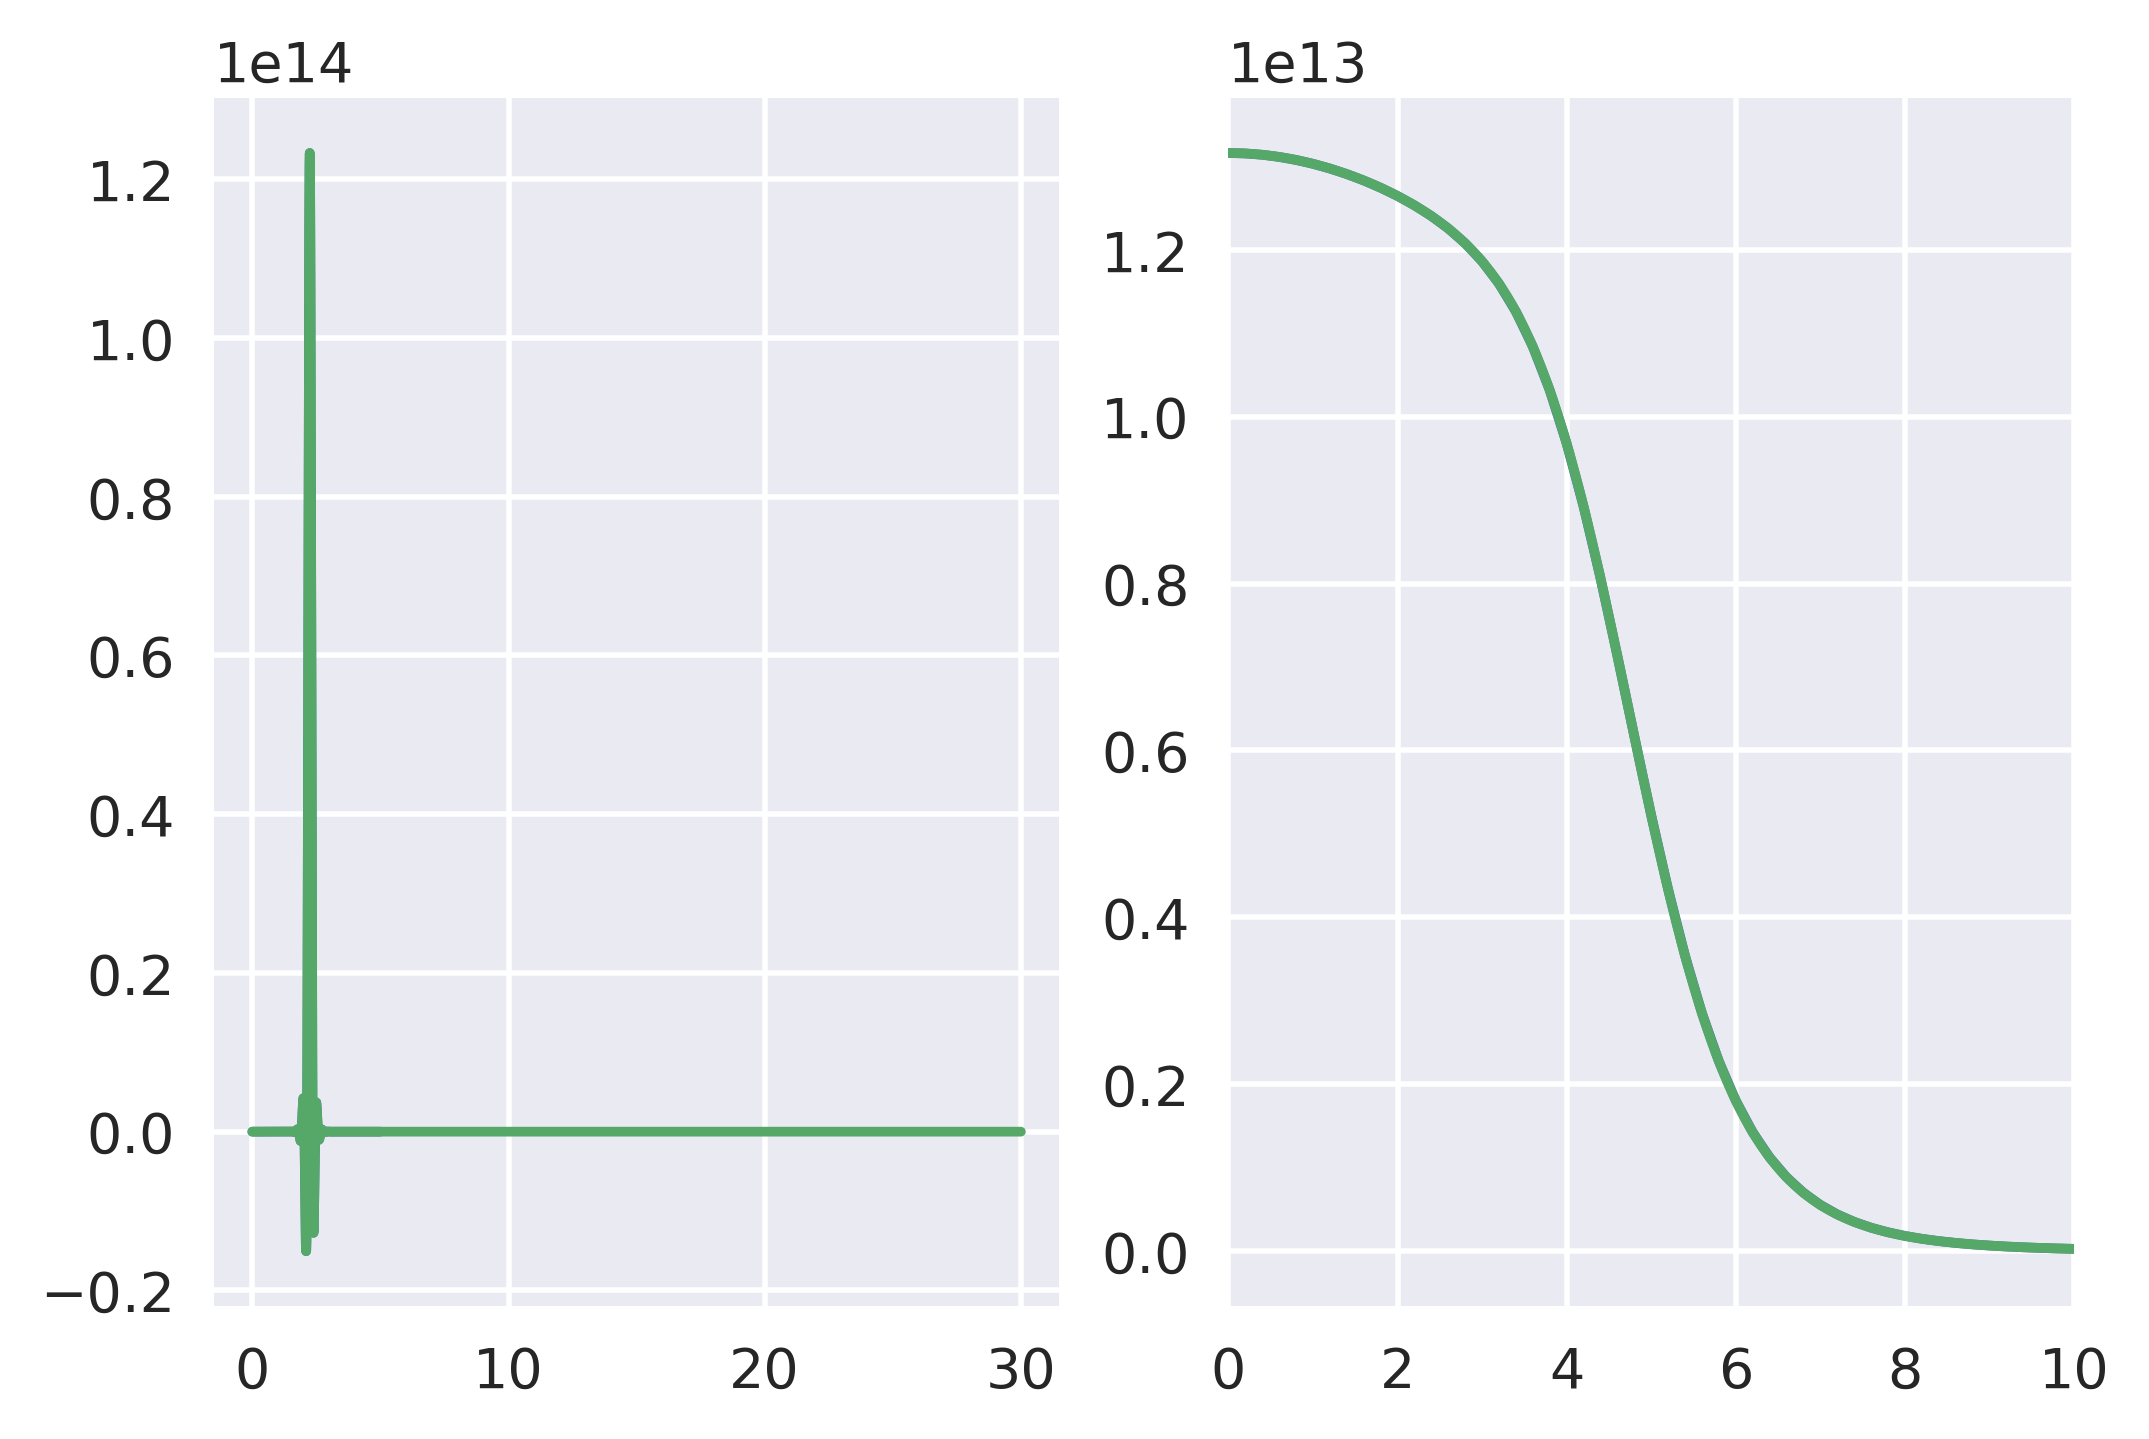

In [49]:
ntsrc = 5000
nsrc = 1560
ksrc = 470
src = np.fromfile(f'input/source_xx', dtype='float32').reshape(nsrc, ntsrc)

dt_src = 0.001
fs = 1 / dt_src
dt_upsrc = dt_upsrc
fsup = 1 / dt_upsrc
isrc = src[ksrc, :]
upsrc = np.interp(np.arange(0, 5, dt_upsrc), np.arange(0, 5, dt_src), isrc)
upsrc = np.fromfile(f'topo_dt04_qf06_s05h005l100/input/source_xx', 
                    dtype='float32').reshape(nsrc, int(tmax / dt_upsrc))[ksrc, :]

fsrc = np.fft.fft(isrc) * dt_src
fupsrc = np.fft.fft(upsrc) * dt_upsrc
freq = np.arange(0, fs, fs / len(fsrc))
upfreq = np.arange(0, fsup, fsup / len(fupsrc))
print(len(freq), np.max(freq))
fig, ax = plt.subplots(1, 2, dpi=400)
ax[0].plot(np.arange(0, 5, dt_src), isrc)
ax[0].plot(np.arange(0, tmax, dt_upsrc), upsrc)

ax[1].plot(freq, np.abs(fsrc))
ax[1].plot(upfreq, np.abs(fupsrc))
ax[1].set_xlim(0, 10)

### Mesh

#### Original 3D

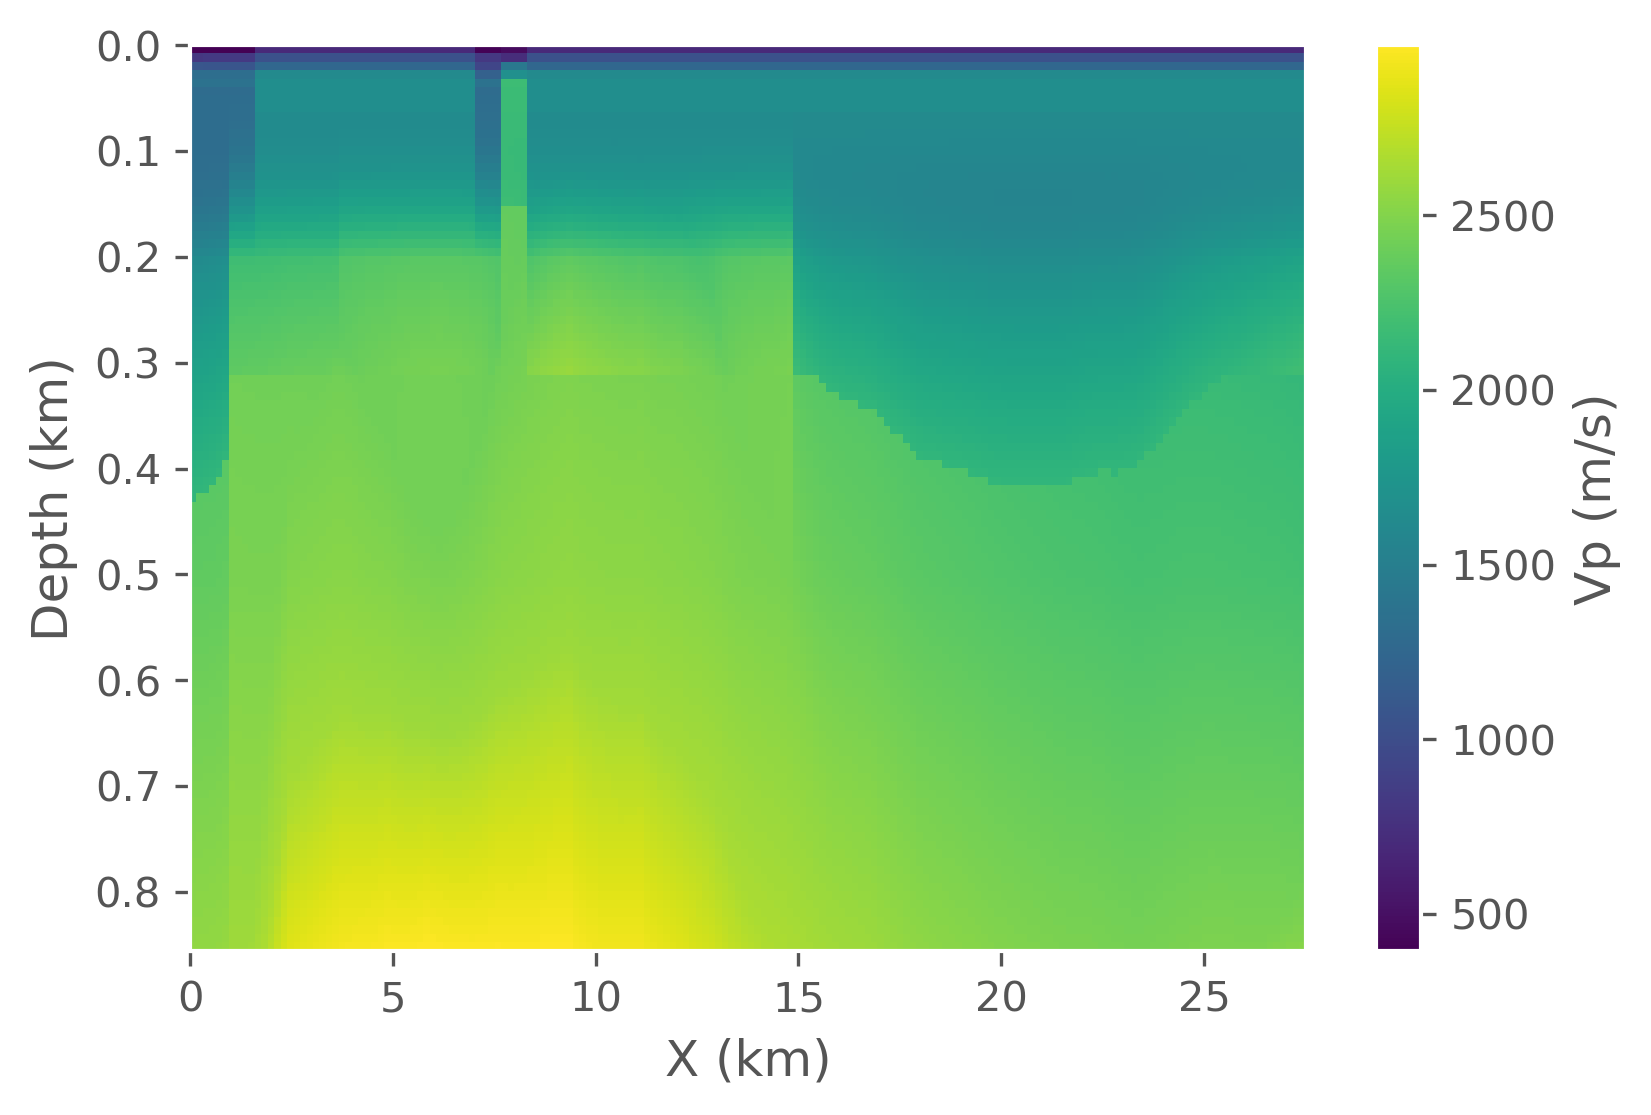

In [148]:
#iy = np.random.randint(my)
vp_0 = np.zeros((108, mx))
with open('mesh_orig_p0.bin', 'rb') as f_mesh_0:
    for k in range(108):
        f_mesh_0.seek(4 * 3 * (k * mx * my + mx * iy), 0)
        buffer = np.frombuffer(f_mesh_0.read(4 * mx * 3),
                               dtype='float32').reshape(-1, 3)
        vp_0[k, :] = buffer[:, 0]
        display.clear_output(wait=True)
plt.pcolor(np.arange(0, mx, 20) * dh, np.arange(108) * dh, vp_0[:, ::20])
cbar = plt.colorbar()
cbar.set_label('Vp (m/s)')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()

#### Het_p0

Vp_max = 3250.0


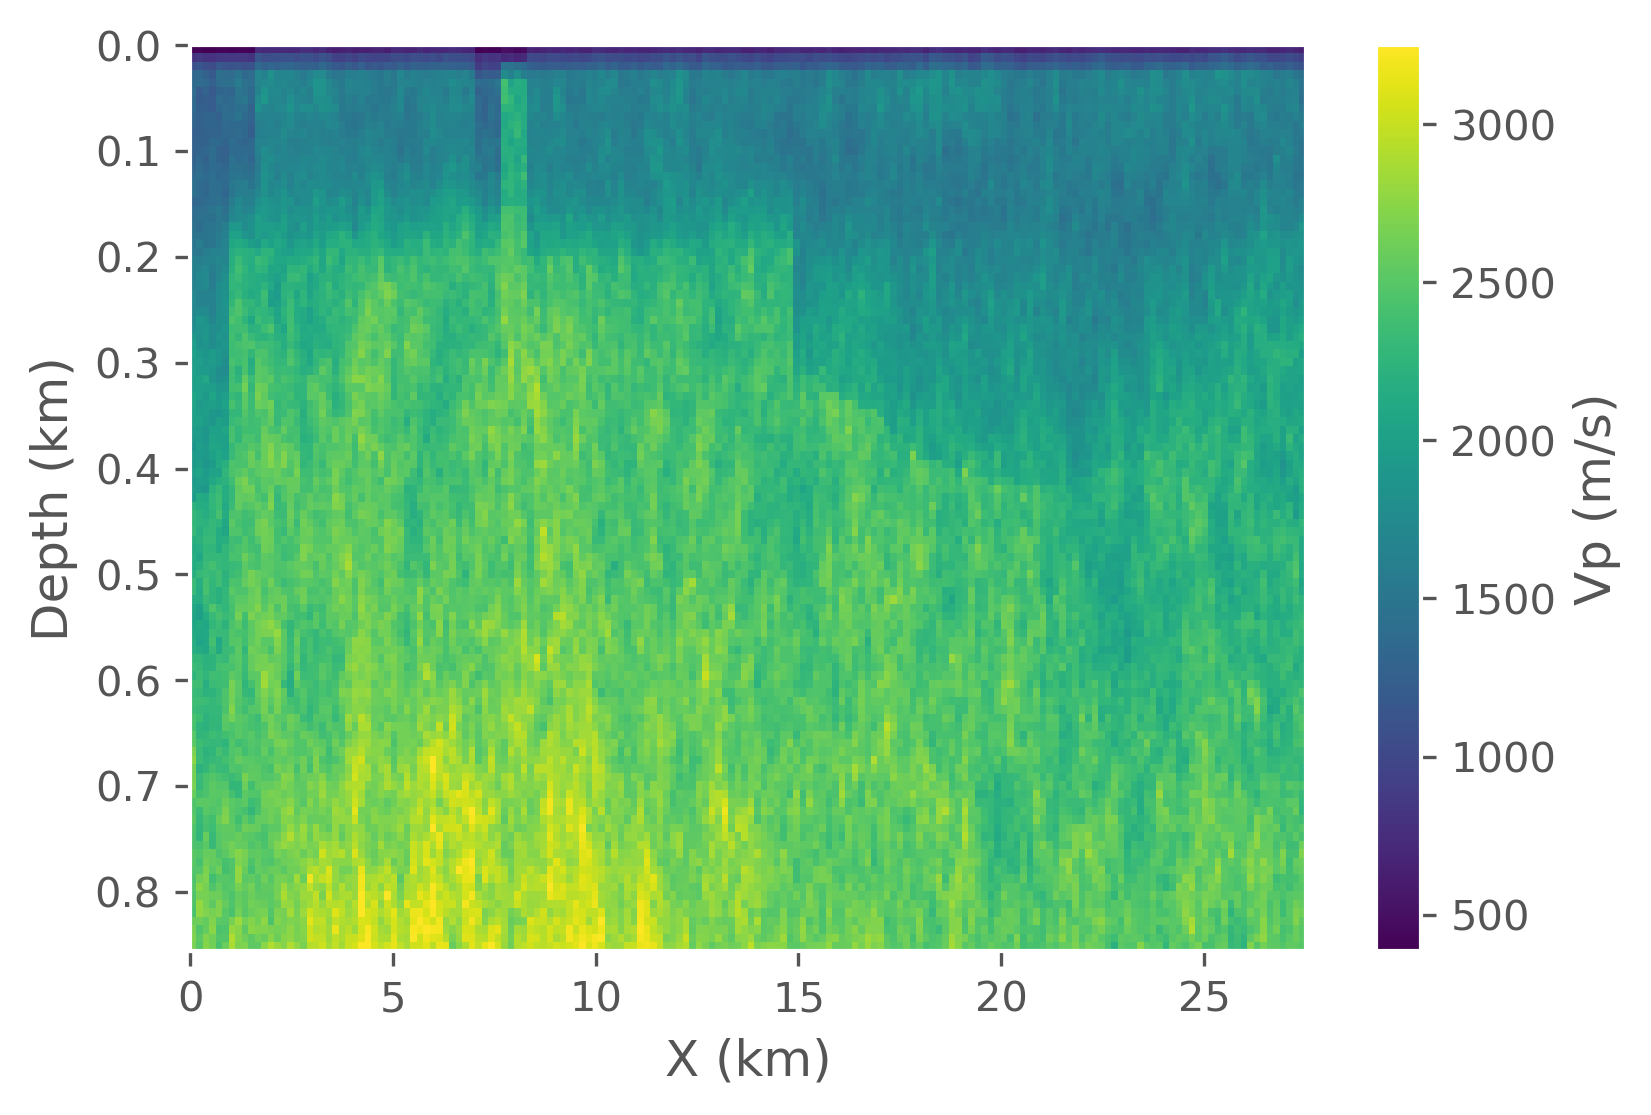

In [147]:
#ix = np.random.randint(mx)
#iy = np.random.randint(my)
vp_0 = np.zeros((108, mx))
with open('mesh_s05h005l100_p0.bin', 'rb') as f_mesh_0:
    for k in range(108):
        f_mesh_0.seek(4 * 3 * (k * mx * my + mx * iy), 0)
        buffer = np.frombuffer(f_mesh_0.read(4 * mx * 3), dtype='float32').reshape(-1, 3)
        vp_0[k, :] = buffer[:, 0]
        display.clear_output(wait=True)
vp_max = np.max(vp_0)
print(f"Vp_max = {vp_max}")
plt.pcolor(np.arange(0, mx, 20) * dh, np.arange(108) * dh, vp_0[:, ::20])
cbar = plt.colorbar()
cbar.set_label('Vp (m/s)')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()

#### Het_p1

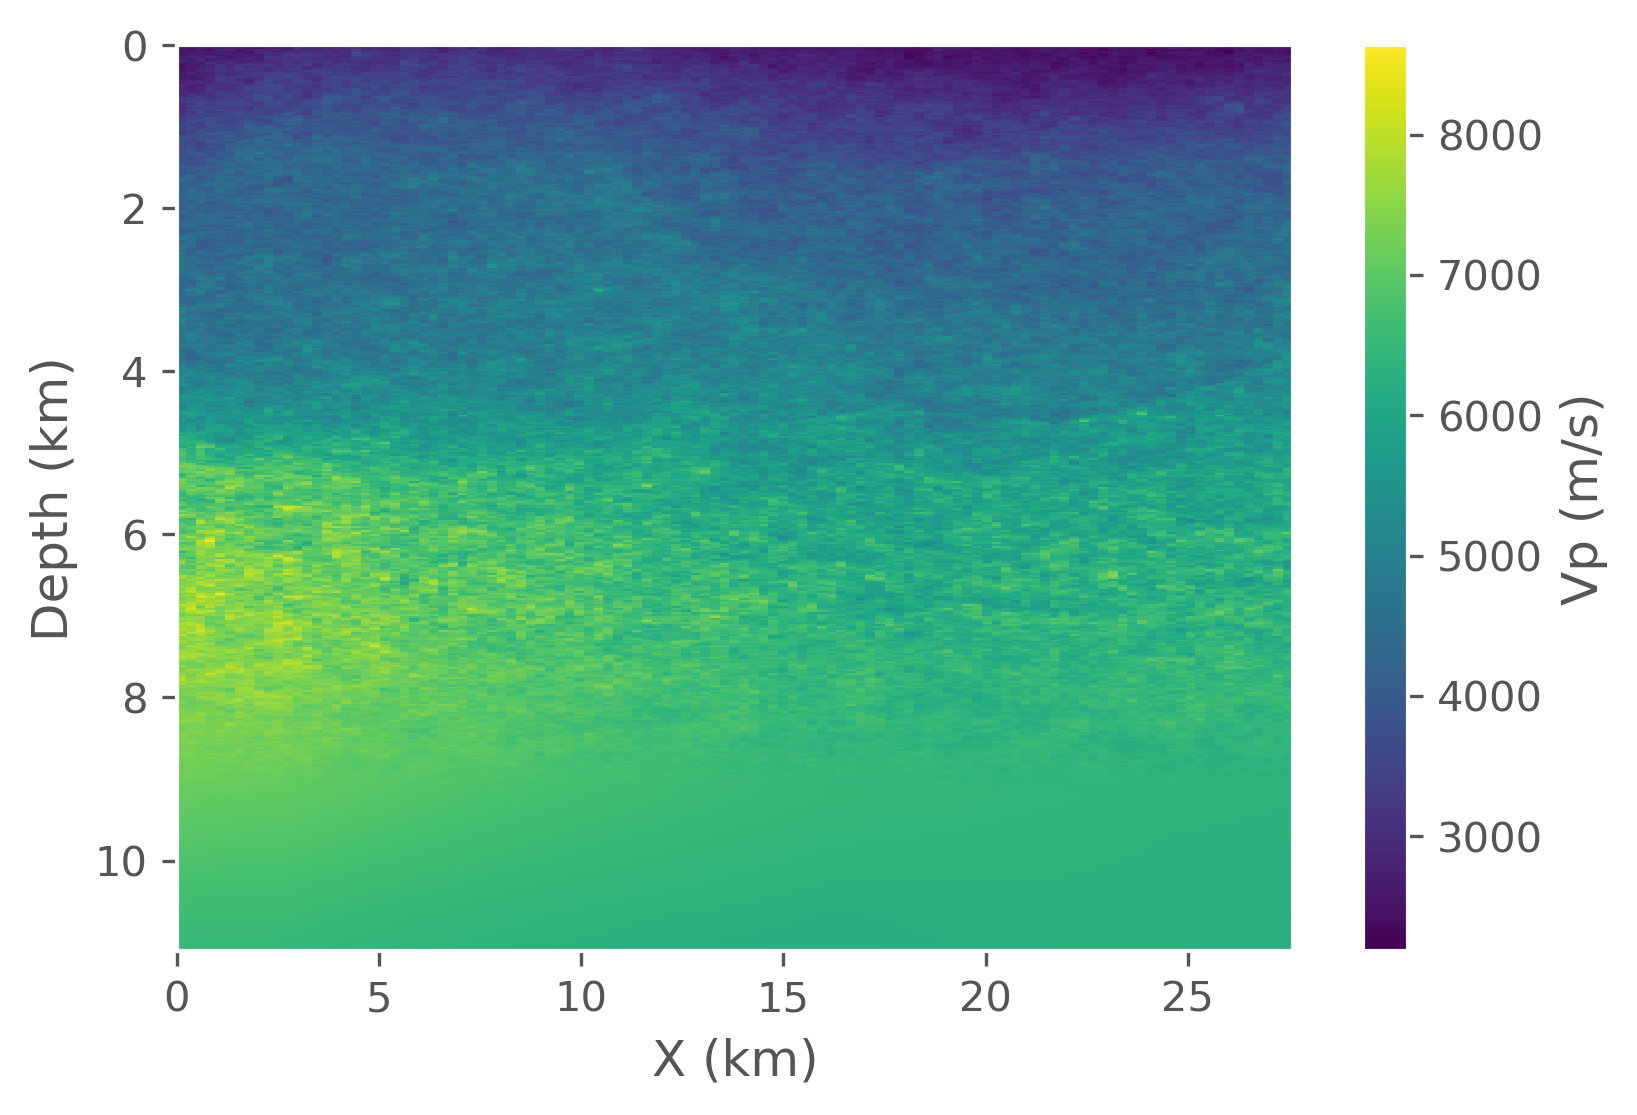

In [149]:
ly = iy // 3
bx, by = mx // 3, my // 3
vp_1 = np.zeros((464, bx))
with open('mesh_s05h005l100_p1.bin', 'rb') as f_mesh_1:
    for k in range(464):
        f_mesh_1.seek(4 * 3 * (k * bx * by + bx * ly), 0)
        buffer = np.frombuffer(f_mesh_1.read(4 * bx * 3),
                               dtype='float32').reshape(-1, 3)
        vp_1[k, :] = buffer[:, 0]
        display.clear_output(wait=True)
plt.pcolor(np.arange(0, bx, 10) * dh * 3,
           np.arange(464) * dh * 3, vp_1[:, ::10])
cbar = plt.colorbar()
cbar.set_label('Vp (m/s)')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()

#### ssh_p0

Check if ssh consistent:
Top and bottom blocks are consistent!
Check if mesh consistent:
Top and bottom blocks are consistent!
Check if mesh with ssh consistent:
Top and bottom blocks are not consistent! Max_diff = 0.00048828125


True

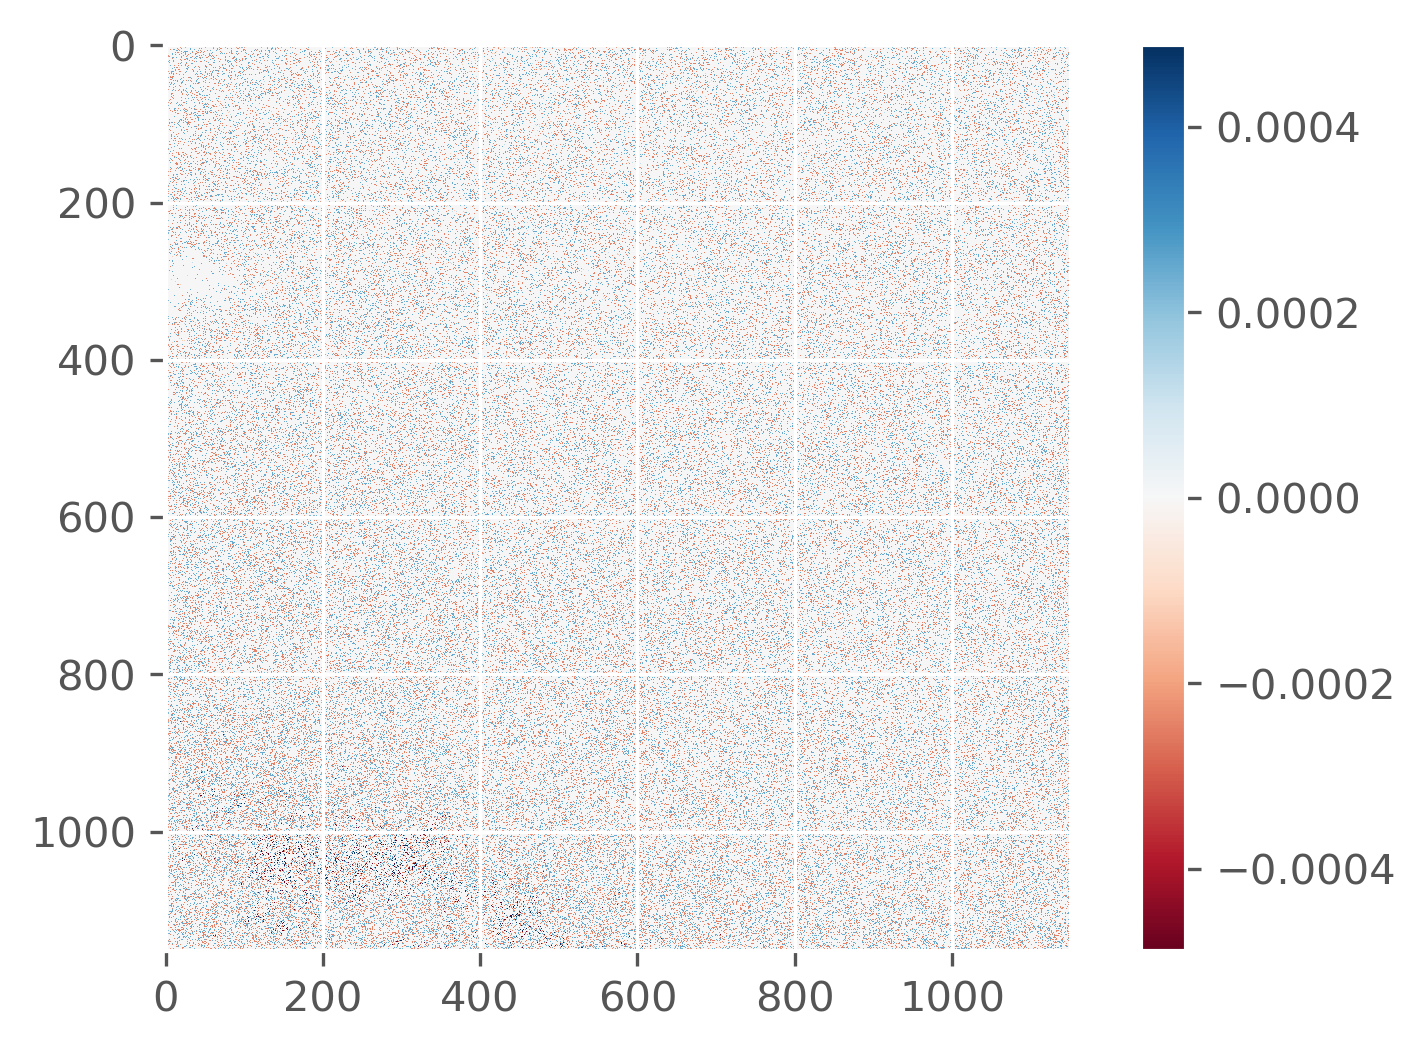

In [115]:
print("Check if ssh consistent:")
check_mesh_cont("../ssh/ssh_8m_s05h005l100.out", "../ssh/ssh_24m_s05h005l100_p1.out", mx, my, 108, nvar=1)
print("Check if mesh consistent:")
check_mesh_cont("mesh_orig_p0.bin", "mesh_orig_p1.bin", mx, my, 108, nvar=3)
print("Check if mesh with ssh consistent:")
check_mesh_cont("mesh_s05h005l100_p0_vp3850.bin", "mesh_s05h005l100_p1.bin", mx, my, 108, nvar=3)


Text(0.5, 0, 'X (km)')

Text(0, 0.5, 'Depth (km)')

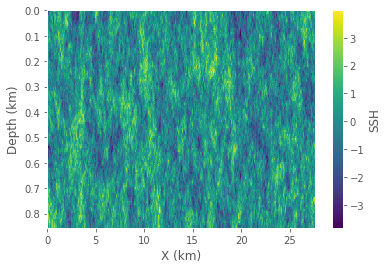

In [86]:
ix = np.random.randint(mx)
iy = np.random.randint(my)
ssh_0 = np.zeros((108, mx))
with open('../ssh/ssh_8m_s05h005l100.out', 'rb') as f_ssh:
    for k in range(108):
        f_ssh.seek(4 * (k * mx * my + mx * iy), 0)
        ssh_0[k, :] = np.frombuffer(f_ssh.read(4 * mx), dtype='float32')
        display.clear_output(wait=True)

plt.pcolor(np.arange(0, mx, 10) * dh, np.arange(108) * dh, ssh_0[:, ::10])
cbar = plt.colorbar()
cbar.set_label('SSH')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()